Code to investigate the predictive models


In [26]:
#Read in the packages to use
import numpy as np
import pandas as pd
import math
import datetime
import os
import pathlib
import matplotlib.pyplot as plt
import earthpy as et
import pandas as pd
import pickle
import random                                                        #for test city selection

#for displaying the cities on map
import cartopy
import cartopy.crs as ccrs
import matplotlib as mpl
from matplotlib.ticker import ScalarFormatter

#models
from sklearn.linear_model import LinearRegression 
import statsmodels.api as sm                                          #stats models to get linear reg p-values
from statsmodels.tools.eval_measures import rmse                      #calc rmse from stats models
import itertools                                                      #for calculating possible combinations of variables
from sklearn.preprocessing import PolynomialFeatures                  #for polynomial regression
from sklearn.pipeline import make_pipeline                            #pipeline to create polynomial regression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF                      #import the kernels for GPR
from sklearn.gaussian_process.kernels import DotProduct
from sklearn.gaussian_process.kernels import Matern

#use grid search to find hyperparameters (pg 73 Geron) RFR
from sklearn.model_selection import GridSearchCV                      #for cross validation
from sklearn.feature_selection import RFE                             #for selecting features for the linear reg
from sklearn.model_selection import cross_val_score                   #for cross validation
from sklearn.model_selection import KFold                            
from sklearn.model_selection import GridSearchCV 
from sklearn.preprocessing import StandardScaler                      #for normalising the data
from sklearn.metrics import r2_score                                  #metrics for assessing model
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

#for plotting
from matplotlib import ticker 
from matplotlib.ticker import MaxNLocator                             #to keep whole numbers on the x-axis
from matplotlib.lines import Line2D                                   #for manual legend creation
from sklearn.inspection import PartialDependenceDisplay               #for the partial dependence plots
#from alibi.explainers import ALE, plot_ale                            #for the ALE plots
import math
#Read in the data
#read in the city info table
#os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT', 'CITY_ADD_2022_09'))
#CITY_COUNTRY_lat_lon = pd.read_excel('CITY_COUNTRY_lat_lon.xlsx', index_col=None)
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT', 'MEAN_SUHI'))
CITY_COUNTRY_lat_lon = pd.read_excel('CITY_COUNTRY_lat_lon_mean.xlsx', index_col=None)

#read the table with all variables in as pickle
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT','UHI_Project_Pickle_Files','All_cities'))   
with open('aqua_all_monthly_data_df2.pkl', 'rb') as f:
    all_monthly_data_df = pickle.load(f)


# Additional variables
# add evi difference variable
all_monthly_data_df['EVI_D'] = all_monthly_data_df['EVI_U'] - all_monthly_data_df['EVI_R'] 

all_monthly_data_df['LOG_AREA'] = np.log10(all_monthly_data_df.Monthly_Area.values.astype(float))
# add sqrt values of climate variables (evi range is -1 to 1)
all_monthly_data_df['sqrt_EF'] = np.sqrt(all_monthly_data_df.EF.values.astype(float))
all_monthly_data_df['sqrt_RH'] = np.sqrt(all_monthly_data_df.RH.values.astype(float))
all_monthly_data_df['sqrt_TP'] = np.sqrt(all_monthly_data_df.TP.values.astype(float))
all_monthly_data_df['sqrt_T2M'] = np.sqrt(all_monthly_data_df.T2M.values.astype(float))
all_monthly_data_df['sqrt_SSR'] = np.sqrt(all_monthly_data_df.SSR.values.astype(float))
# add one to the sqrt (evi variables +1)
all_monthly_data_df['sqrt_EVI_R_p1'] = np.sqrt(all_monthly_data_df.EVI_R.values.astype(float)+1)
all_monthly_data_df['sqrt_EVI_U_p1'] = np.sqrt(all_monthly_data_df.EVI_U.values.astype(float)+1)
all_monthly_data_df['sqrt_EVI_D_p1'] = np.sqrt(all_monthly_data_df.EVI_D.values.astype(float)+1)
all_monthly_data_df['CROPLAND'] = all_monthly_data_df['CROPLAND_RAIN'] + all_monthly_data_df['CROPLAND_IRR']
# elevation diff
all_monthly_data_df['ELEVATION_D'] = all_monthly_data_df['ELEVATION_U'] - all_monthly_data_df['ELEVATION_R']

#split into training and test data
#take the test data as 4 cities, the training as 14?
#or test as 3 cities, training as 15

#define the test cities to remove
#create a list of the candiates
test_candidates = CITY_COUNTRY_lat_lon.copy()

#get one letter koppen geiger
koppen_1_list = []
for i in range(len(test_candidates)):
    koppen_1_letter = test_candidates.koppen_climate[i][0]
    koppen_1_list.append(koppen_1_letter)
    
test_candidates['koppen_1_letter'] = koppen_1_list

#randomly pick test cities from each group
#9 cities to be chosen
#5 from A, 7 from B, 6 from C
num_A = len(test_candidates[test_candidates['koppen_1_letter'] == 'A'])
num_B = len(test_candidates[test_candidates['koppen_1_letter'] == 'B'])
num_C = len(test_candidates[test_candidates['koppen_1_letter'] == 'C'])
num_D = len(test_candidates[test_candidates['koppen_1_letter'] == 'D'])

# generate random test cities
test_cities = random.sample([*set(test_candidates[test_candidates['koppen_1_letter'] == 'A'].City.values)], k=5)
test_cities = test_cities + (random.sample([*set(test_candidates[test_candidates['koppen_1_letter'] == 'B'].City.values)],
                                           k=5))
test_cities = test_cities + (random.sample([*set(test_candidates[test_candidates['koppen_1_letter'] == 'C'].City.values)],
                                           k=6))


#define the overpass time 
overpass_time = '13:30'
#overpass_time = '01:30'


if overpass_time == '13:30':
    overpass_file_name = '1330'
else:
    overpass_file_name = '0130'

#define the predictor and target values for training and test data
#what predictors to use?
predictor_variables_all = ['EF', 'RH', 'TP','T2M','SSR','EVI_U','EVI_R','EVI_D',
                           'ECC', 'LOG_AREA', 'sqrt_EF','sqrt_RH','sqrt_TP','sqrt_T2M',
                           'sqrt_SSR','sqrt_EVI_R_p1','sqrt_EVI_U_p1','sqrt_EVI_D_p1','CROPLAND_RAIN',
                           'CROPLAND_IRR','GRASSLAND','BARE','WATER']

predictor_variables_1 = ['EF','SSR','EVI_U','EVI_R','EVI_D', 'ECC', 'LOG_AREA', 
                         'sqrt_EF','sqrt_SSR', 'sqrt_EVI_R_p1','sqrt_EVI_U_p1','sqrt_EVI_D_p1',
                         'ELEVATION_D','CROPLAND','GRASSLAND', 'WATER','BARE']

predictor_variables_2 = ['EF','SSR','EVI_U','EVI_R','EVI_D', 'ECC', 'LOG_AREA', 
                         'ELEVATION_D','CROPLAND','GRASSLAND', 'WATER','BARE']


predictor_variables = predictor_variables_2

#target_variable = 'SUHI_PEAK_GSA'
#target_variable = 'SUHI_PEAK_QUANTILE'
target_variable = 'SUHI_MEAN'
#target_variable = 'SUHI_FP'

#clean the data - first remove columns which are not the target or predictor variables, then remove nans
variables = predictor_variables.copy()
variables.append(target_variable)
variables.append('City')
variables.append('Overpass')
all_monthly_data_df2 = all_monthly_data_df[variables]
all_monthly_data_df2 = all_monthly_data_df2.dropna().reset_index(drop = True)

all_monthly_data_df3 = all_monthly_data_df[['EF','SSR','EVI_U','EVI_R','EVI_D', 'ECC', 'LOG_AREA', 'sqrt_EF','sqrt_SSR',
            'sqrt_EVI_R_p1','sqrt_EVI_U_p1','sqrt_EVI_D_p1', 'CROPLAND','WATER','BARE','GRASSLAND','month','City',
                                            'Overpass']].dropna().reset_index(drop = True)


#annual averages 
#annual_data = all_monthly_data_df.groupby(['City', 'Overpass','year']).mean().reset_index()
#annual_data2 = annual_data[variables]
#annual_data2 = annual_data2.dropna().reset_index(drop = True)
#training_data = annual_data2[((~annual_data2['City'].isin(test_cities)) 
#                                    & (annual_data2['Overpass'] == overpass_time))].copy()
#test_data = annual_data2[((annual_data2['City'].isin(test_cities))
#                                  & (annual_data2['Overpass'] == overpass_time))].copy()

#create training and test datasets
training_data = all_monthly_data_df2[((~all_monthly_data_df2['City'].isin(test_cities)) 
                                    & (all_monthly_data_df2['Overpass'] == overpass_time))].copy()
test_data = all_monthly_data_df2[((all_monthly_data_df2['City'].isin(test_cities))
                                  & (all_monthly_data_df2['Overpass'] == overpass_time))].copy()


print('Train_percent', 100* len(training_data)/len(all_monthly_data_df2[all_monthly_data_df2['Overpass'] == overpass_time]))
print('Test_percent', 100* len(test_data)/len(all_monthly_data_df2[all_monthly_data_df2['Overpass'] == overpass_time]))
print('Total Datapoints',len(all_monthly_data_df2[all_monthly_data_df2['Overpass'] == overpass_time]))

#split the data into training and test
X_train = training_data[predictor_variables]  #predictors
y_train = training_data[target_variable]      #target

X_test = test_data[predictor_variables]       #predictors
y_test = test_data[target_variable]           #target


# get polynomail terms and interactions
poly = PolynomialFeatures(2)
X_train_poly = pd.DataFrame(poly.fit_transform(X_train), columns = poly.get_feature_names_out(X_train.columns))
X_train_poly = X_train_poly.drop('1', axis=1)

X_test_poly = pd.DataFrame(poly.fit_transform(X_test), columns = poly.get_feature_names_out(X_test.columns))
X_test_poly = X_test_poly.drop('1', axis=1)

# prune
#X_train_poly = X_train_poly[Predictor_Variables_pruned]
#X_test_poly = X_test_poly[Predictor_Variables_pruned]

#get the groups
groups_train = training_data.City
groups_test = test_data.City

#create normalised datasets
#the test dataset is normalised using the normalisation parameters from the training data
scaler = StandardScaler()
X_train_poly_norm = pd.DataFrame(scaler.fit_transform(X_train_poly), columns = X_train_poly.columns) #fit and transform
X_test_poly_norm = pd.DataFrame(scaler.transform(X_test_poly), columns = X_test_poly.columns) #transform only

X_train_norm = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns) #fit and transform
X_test_norm = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns) #transform only

y_train_norm = pd.DataFrame(scaler.fit_transform(y_train.values.reshape(-1,1)), columns = [target_variable]) #fit and transform
y_test_norm = pd.DataFrame(scaler.transform(y_test.values.reshape(-1, 1)), columns = [target_variable]) #transform only


Train_percent 85.7176953553869
Test_percent 14.282304644613108
Total Datapoints 20949


In [930]:
#checking if the cities have all been run as test cities yet
import fnmatch
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts','PROJECT','MEAN_SUHI','Seasonal_cycles_RR_preds_EVI_U'
                             ,'TEST_CITIES')) 

file_list = []
city_list = []
for city_name in CITY_COUNTRY_lat_lon.City.values:#test_cities:
    for file in os.listdir('.'):
        if fnmatch.fnmatch(file, '*{}*'.format(city_name)):
            file_list.append(file)
            city_list.append(city_name)
            
            
len(file_list)

128

In [834]:
CITY_COUNTRY_lat_lon[~CITY_COUNTRY_lat_lon.City.isin(city_list)]

,CITY_COUNTRY,City,Lat,Lon,City_Area,City_Bound_xmin,City_Bound_xmax,City_Bound_ymin,City_Bound_ymax,koppen_climate,...,eccen_2018,major_ax_2019,minor_ax_2019,ell_theta_2019,eccen_2019,major_ax_2020,minor_ax_2020,ell_theta_2020,eccen_2020,std_dev_elevation
62,SANHE_CHINA,Sanhe,39.981938,117.07133,29,-4000,4000,-3000,3000,Dwa,...,0.744609,4021.387153,2684.280207,0.172152,0.744609,4021.387153,2684.280207,0.172152,0.744609,82.068619


In [772]:
#len(set(CITY_COUNTRY_lat_lon.Grid_Ref))
#len(CITY_COUNTRY_lat_lon.City)

View Train and Test cities

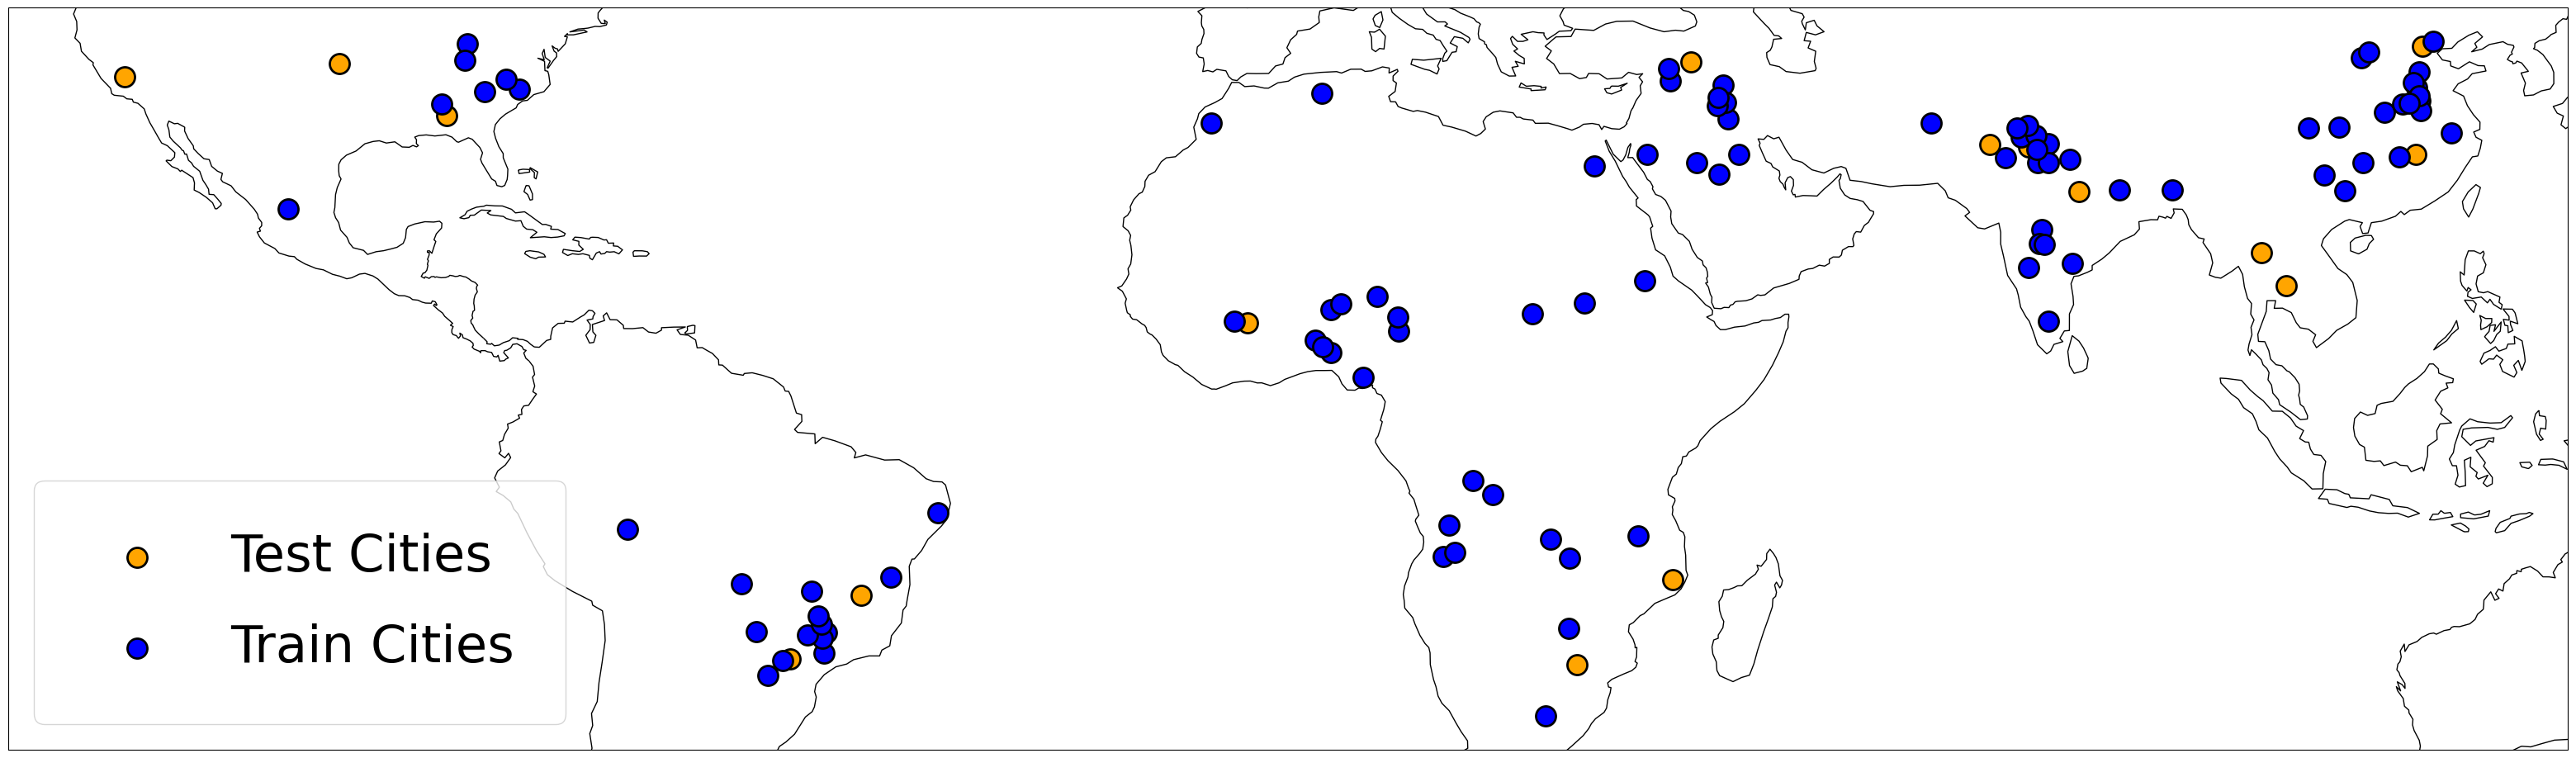

In [127]:
#Display train and test cities
#plot of where the test and training cities are located
fig = plt.figure(figsize=(40,35))

test_lats = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['City'].isin(test_cities)]['Lat']
test_lons = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['City'].isin(test_cities)]['Lon']

train_lats = CITY_COUNTRY_lat_lon[~CITY_COUNTRY_lat_lon['City'].isin(test_cities)]['Lat']
train_lons = CITY_COUNTRY_lat_lon[~CITY_COUNTRY_lat_lon['City'].isin(test_cities)]['Lon']

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

ax.scatter(test_lons, test_lats, zorder=5,color='orange', label='Test Cities', linewidths = 2, s =300,edgecolor = 'black')
ax.scatter(train_lons, train_lats, zorder=5,color='blue', label='Train Cities', linewidths = 2, s =300,edgecolor = 'black')

ax.legend(loc=3, borderpad = 1, fontsize = 45, labelspacing=0.8)

In [ ]:
#create dictionary of the classifications at the correct level of detail (2 letters here)
koppen_dict = {'As':'Tropical Savannah','Aw': 'Tropical Savannah', 'Am':'Tropical Monsoon','BSh':'Arid Steppe' ,
               'BSk':'Arid Steppe', 'BWh':'Arid Desert','BWk':'Arid Desert' ,'Cfa':'Temperate, no dry season', 
               'Cwa':'Temperate, dry winter', 'Cwb':'Temperate, dry winter','Csa':'Temperate, dry summer',
               'Csc':'Temperate, dry summer','Dwa':'Snow, Dry Winter'}

#create dictionary for the colors
color_dict = {'Tropical Savannah':'royalblue','Arid Steppe': 'saddlebrown', 'Arid Desert': 'orange', 
              'Temperate, no dry season':'forestgreen','Temperate, dry winter':'olive','Temperate, dry summer':'lawngreen',
             'Tropical Monsoon':'navy','Snow, Dry Winter':'snow'}
#use the dictionary to create a new column containing the descriptions
CITY_COUNTRY_lat_lon['koppen_desc'] = CITY_COUNTRY_lat_lon.koppen_climate
CITY_COUNTRY_lat_lon = CITY_COUNTRY_lat_lon.replace({"koppen_desc": koppen_dict})

In [ ]:
# View cities with the climate classification as the key
#change the legend title fontsize
plt.rcParams['legend.title_fontsize'] = 40
plt.rc('axes', titlesize=45)     # fontsize of the axes title

#create list of sorted definitions
desc_list = list(set(CITY_COUNTRY_lat_lon.koppen_desc))
desc_list.sort()

fig = plt.figure(figsize=(40,65))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

for koppen_desc in desc_list:

    city_lats = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['koppen_desc']==koppen_desc]['Lat']
    city_lons = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['koppen_desc']==koppen_desc]['Lon']
    climate_color = color_dict[koppen_desc]
    
    ax.scatter(city_lons, city_lats, zorder=5, color=climate_color, label=koppen_desc, 
               linewidths = 2, s =300,edgecolor = 'black')

ax.legend(title = 'Climate Type', loc=3, borderpad = 1, fontsize = 25, labelspacing=0.8)
ax.set(title = 'Selected Cities by Koppen Geiger Climate Classification')
#save figure as png
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT','Graphs_outputs','pred_modelling'))   
plt.savefig('climate_class_map.png', bbox_inches = 'tight')

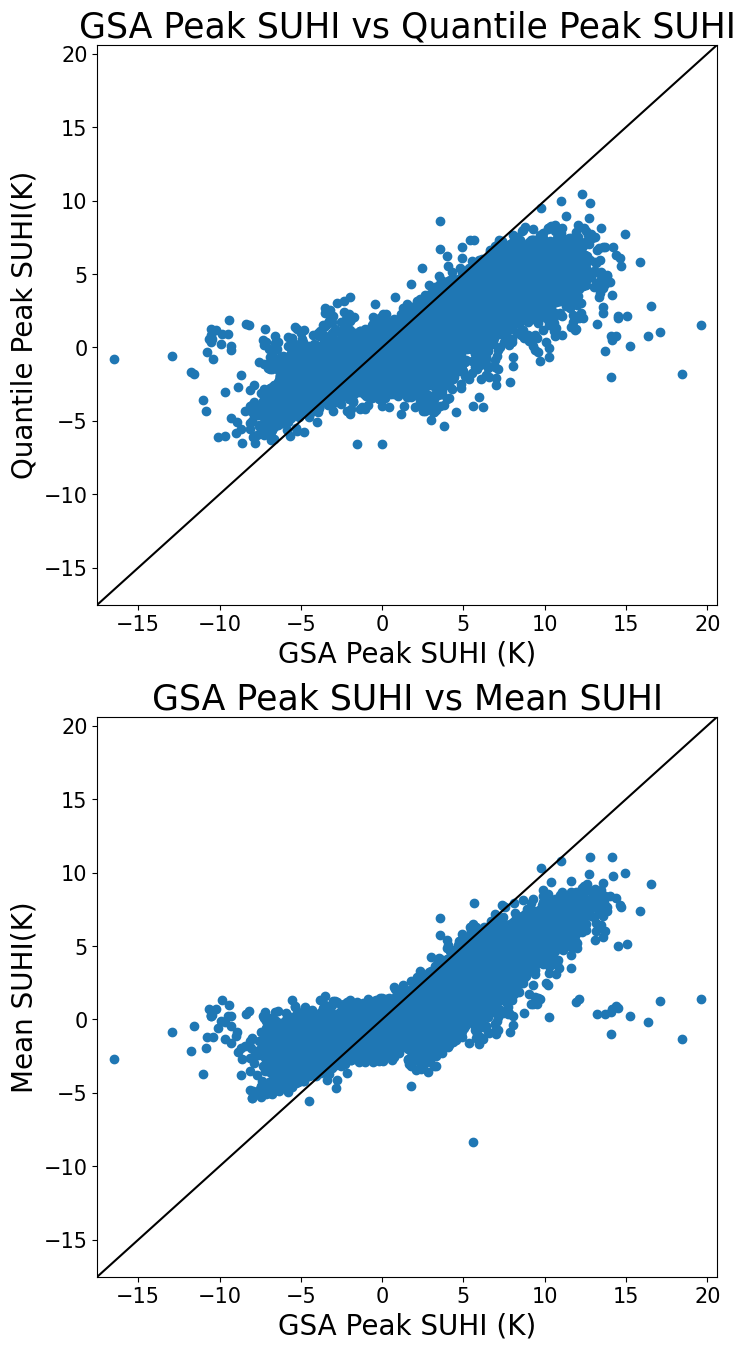

In [4]:
###########################################################
### Scatter plot of SUHI_PEAK_GSA vs SUHI_PEAK_QUANTILE ###
###    Scatter plot of SUHI_PEAK_GSA vs SUHI_MEAN       ###
###########################################################

# PLOTS: obvs vs predictions

#plt.rc('font', size=15)          # controls default text sizes
plt.rc('axes', titlesize=25)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
#plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title

fig, axes = plt.subplots(2,1, figsize = (8, 16))

SUHI_PEAK_GSA = all_monthly_data_df[all_monthly_data_df['Overpass'] == overpass_time].SUHI_PEAK_GSA
SUHI_PEAK_QUANTILE = all_monthly_data_df[all_monthly_data_df['Overpass'] == overpass_time].SUHI_PEAK_QUANTILE
SUHI_MEAN = all_monthly_data_df[all_monthly_data_df['Overpass'] == overpass_time].SUHI_MEAN

axes[0].scatter(SUHI_PEAK_GSA, SUHI_PEAK_QUANTILE)
axes[0].set(title = 'GSA Peak SUHI vs Quantile Peak SUHI', 
         xlabel = 'GSA Peak SUHI (K)', ylabel = 'Quantile Peak SUHI(K)')

axesmin = min(min(SUHI_PEAK_GSA), min(SUHI_PEAK_QUANTILE)) - 1
axesmax = max(max(SUHI_PEAK_GSA), max(SUHI_PEAK_QUANTILE)) + 1

axes[0].set_xlim([axesmin, axesmax])
axes[0].set_ylim([axesmin, axesmax])

axes[0].plot([axesmin, axesmax],[axesmin, axesmax], color = 'k')

axes[1].scatter(SUHI_PEAK_GSA, SUHI_MEAN)
axes[1].set(title = 'GSA Peak SUHI vs Mean SUHI', 
         xlabel = 'GSA Peak SUHI (K)', ylabel = 'Mean SUHI(K)')

axesmin = min(min(SUHI_PEAK_GSA), min(SUHI_MEAN)) - 1
axesmax = max(max(SUHI_PEAK_GSA), max(SUHI_MEAN)) + 1

axes[1].set_xlim([axesmin, axesmax])
axes[1].set_ylim([axesmin, axesmax])

axes[1].plot([axesmin, axesmax],[axesmin, axesmax], color = 'k')

#save figure as png
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT','Graphs_outputs','pred_modelling'))   
plt.savefig('GSA_Quantile_Mean_Scatters_{}.png'.format(overpass_file_name), bbox_inches = 'tight')


In [5]:
plt.rc('axes', labelsize=30)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels

X_scatters = pd.concat([X_train_poly, X_test_poly]).reset_index(drop = True)
Y_scatters = pd.concat([pd.DataFrame(data = y_train, columns = ['SUHI_PEAK_GSA']), 
                        pd.DataFrame(data = y_test, columns = ['SUHI_PEAK_GSA'])]).reset_index(drop = True)

num_cols = 4
num_rows = math.ceil(len(X_scatters.columns)/num_cols)

fig, axes = plt.subplots(num_rows,num_cols, figsize = (50, 400))
for i, pred_variable in enumerate(X_scatters.columns):
    x = X_scatters[pred_variable]
    y = Y_scatters.values
    plotrow = int((i - i%4)/4)
    plotcol = i%4
    axes[plotrow, plotcol].scatter(x, y)
    axes[plotrow, plotcol].set(xlabel = pred_variable, ylabel = 'SUHI_PEAK_GSA' )
    
os.chdir(os.path.join(et.io.HOME, 'Documents', 'UEA','Urban_Heat','PROJECT','Writing_up',
                          'Meeting_Documents','2022','2022_11_11'))   
plt.savefig('scatter_matrix.png', bbox_inches = 'tight')   

ValueError: x and y must be the same size

In [6]:
##########################
#### RIDGE REGRESSION ####
##########################

folds = 5    #define the number of folds (K)

#define regression model
ridge_reg = Ridge(fit_intercept=True)
#specify the hyperparameters to test
hyper_params = {'alpha':[0,1e-10,1,100,400, 500,600,700, 800, 1000, 1500,2000,2500,3000,4000, 5000,6000,7000,8000,9000, 10000,11000,15000,20000,30000]}
#hyper_params = {'alpha':[0,1e-10,1, 10,20,50,70,100,110,120,130,150,200, 250, 300, 500, 600,650, 700,750,800, 900, 2500]}


#use cross validation to determine the hyperparameter value
model_cv = GridSearchCV(estimator = ridge_reg, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True) 
#fit the model
model_cv.fit(X_train_poly_norm, y_train)  

#model_cv.fit(X_train_norm, y_train) 


#cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

Fitting 5 folds for each of 25 candidates, totalling 125 fits


C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.92358e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.74595e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.21658e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA_Laptop\.conda\envs\suhienv2\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.21803e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\UEA

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.177840,4.541648e-03,0.007113,0.005064,0,{'alpha': 0},0.657628,-5.230703,0.306012,0.641940,...,-12.134567,22.567682,25,0.825858,0.798514,0.839208,0.834006,0.824761,0.824469,0.014028
1,0.059784,1.025881e-02,0.007212,0.004640,0.0,{'alpha': 1e-10},0.678355,-5.312018,0.335119,0.643820,...,-12.037830,22.364252,24,0.827207,0.799143,0.839578,0.834624,0.825039,0.825118,0.013990
2,0.055356,1.088608e-02,0.003989,0.003397,1,{'alpha': 1},0.709081,-0.476781,0.402283,0.649673,...,-5.889649,12.428684,23,0.818941,0.789674,0.833880,0.827782,0.816974,0.817450,0.015170
3,0.050004,6.240242e-03,0.003119,0.006239,100,{'alpha': 100},0.705617,0.721768,0.641945,0.666585,...,0.666733,0.044529,22,0.812747,0.779778,0.824907,0.821810,0.806601,0.809169,0.016067
4,0.061256,1.265930e-02,0.010631,0.005424,400,{'alpha': 400},0.703692,0.738461,0.649018,0.673129,...,0.692403,0.030102,14,0.805928,0.774226,0.817974,0.814425,0.798134,0.802137,0.015564
5,0.054945,1.031006e-02,0.042654,0.074230,500,{'alpha': 500},0.702971,0.740677,0.650240,0.672873,...,0.694355,0.030794,10,0.804156,0.772834,0.816350,0.812717,0.796233,0.800458,0.015475
6,0.058417,8.572568e-03,0.004720,0.006266,600,{'alpha': 600},0.702297,0.742188,0.651220,0.672374,...,0.695632,0.031413,8,0.802541,0.771556,0.814878,0.811201,0.794547,0.798945,0.015405
7,0.067853,5.468429e-03,0.008178,0.000746,700,{'alpha': 700},0.701669,0.743234,0.651984,0.671761,...,0.696489,0.031949,6,0.801056,0.770368,0.813526,0.809831,0.793025,0.797561,0.015347
8,0.056061,7.612010e-03,0.010968,0.006232,800,{'alpha': 800},0.701084,0.743964,0.652564,0.671101,...,0.697070,0.032414,4,0.799682,0.769255,0.812273,0.808576,0.791633,0.796284,0.015300
9,0.053117,7.658337e-03,0.006249,0.007653,1000,{'alpha': 1000},0.700027,0.744820,0.653298,0.669761,...,0.697716,0.033184,2,0.797206,0.767214,0.810007,0.806332,0.789155,0.793983,0.015229


In [7]:
model_cv.best_params_

{'alpha': 1500}

In [911]:
chosen_alpha = list(model_cv.best_params_.values())[0]

In [912]:
chosen_alpha

1500

In [934]:
RR_model = Ridge(alpha=20000)
RR_model.fit(X_train_poly_norm, y_train)
#RR_model.fit(X_train_norm, y_train)

Ridge(alpha=20000)

In [935]:
d = {'Predictor_Variable': X_train_poly_norm.columns, 'Coefficients': RR_model.coef_}
coeff_df = pd.DataFrame(data=d)

In [936]:
coeff_df['Coefficient_Magnitude'] = abs(coeff_df.Coefficients)
coeff_df = coeff_df.sort_values(by = 'Coefficient_Magnitude', ascending=False).reset_index(drop = True)

In [937]:
coeff_df

,Predictor_Variable,Coefficients,Coefficient_Magnitude
0,CROPLAND BARE,0.063663,0.063663
1,LOG_AREA CROPLAND,0.040570,0.040570
2,CROPLAND^2,0.032107,0.032107
3,sqrt_EVI_D_p1 CROPLAND,0.030189,0.030189
4,LOG_AREA sqrt_SSR,0.029870,0.029870
...,...,...,...
165,EVI_U GRASSLAND,-0.000489,0.000489
166,EVI_U sqrt_SSR,-0.000292,0.000292
167,CROPLAND WATER,-0.000203,0.000203
168,ECC sqrt_EVI_D_p1,-0.000197,0.000197


In [923]:
list(Predictor_Variables_pruned)

['EVI_R sqrt_EVI_D_p1']

In [897]:
Predictor_Variables_pruned = coeff_df[coeff_df.Coefficient_Magnitude > 0.9].Predictor_Variable.values

In [898]:
len(Predictor_Variables_pruned)

In [899]:
#os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT', 'CITY_ADD_2022_09'))
#coeff_df.to_excel("coeff_df.xlsx")

In [8]:
#Performance stats for ridge regression
y_train_pred = model_cv.predict(X_train_poly_norm)
y_test_pred = model_cv.predict(X_test_poly_norm)

#y_train_pred = model_cv.predict(X_train_norm)
#y_test_pred = model_cv.predict(X_test_norm)

#####################################################
###### Performance Metrics for the training set ######
######################################################
#rmse
train_ridge_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
#r-square~
train_ridge_r2 = r2_score(y_train, y_train_pred)
#mae
train_ridge_mae = mean_absolute_error(y_train, y_train_pred)
print('Training Metrics--', 'RMSE:', train_ridge_rmse, 'R-square:', train_ridge_r2, 'MAE:', train_ridge_mae)

#################################################
###### Performance Metrics for the test set #####
#################################################
#rmse
test_ridge_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
#r-square
test_ridge_r2 = r2_score(y_test, y_test_pred)
#mae
test_ridge_mae = mean_absolute_error(y_test, y_test_pred)
print('Test Metrics--', 'RMSE:', test_ridge_rmse, 'R-square:', test_ridge_r2, 'MAE:', test_ridge_mae)


Training Metrics-- RMSE: 1.1256202267661455 R-square: 0.7878695351973701 MAE: 0.8467827895853246
Test Metrics-- RMSE: 1.1294928568635878 R-square: 0.7306421709253045 MAE: 0.8848565329850757


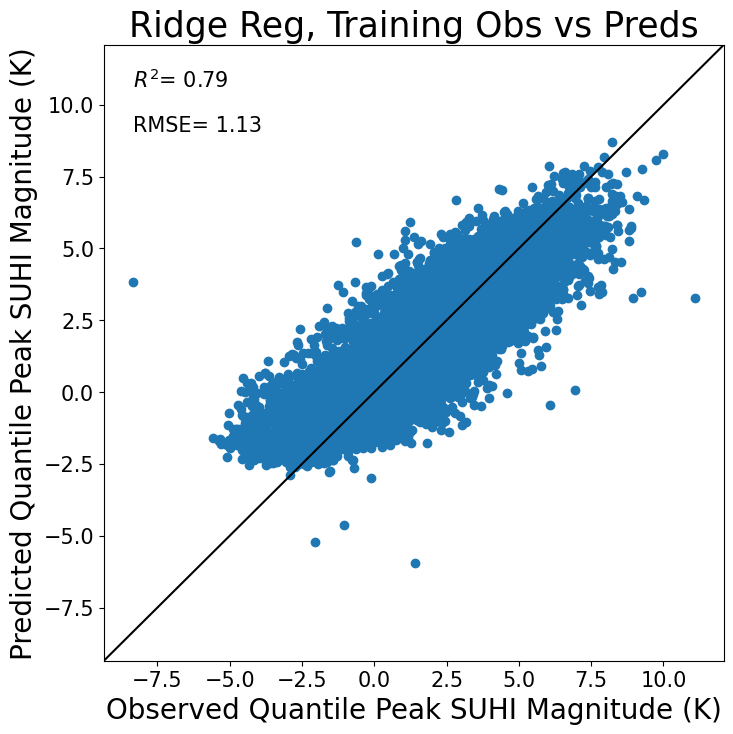

In [9]:
# PLOTS: obvs vs predictions

#plt.rc('font', size=15)          # controls default text sizes
plt.rc('axes', titlesize=25)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
#plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title

fig, axes = plt.subplots(1,1, figsize = (8, 8))

axes.scatter(y_train, y_train_pred)
axes.set(title = 'Ridge Reg, Training Obs vs Preds', 
         xlabel = 'Observed Quantile Peak SUHI Magnitude (K)', ylabel = 'Predicted Quantile Peak SUHI Magnitude (K)')
         #xlabel = 'Observed SUHI Mean (K)', ylabel = 'Predicted SUHI Mean (K)')

axesmin = min(min(y_train), min(y_train_pred)) - 1
axesmax = max(max(y_train), max(y_train_pred)) + 1

axes.set_xlim([axesmin, axesmax])
axes.set_ylim([axesmin, axesmax])

axes.plot([axesmin, axesmax],[axesmin, axesmax], color = 'k')

axes.text(axesmin+1, axesmax-1.5, r'$R^2$= {}'.format(round(train_ridge_r2, 2)), fontsize=15)
axes.text(axesmin+1, axesmax-3, 'RMSE= {}'.format(round(train_ridge_rmse, 2)), fontsize=15)

#axes.text(-7, 10, r'$R^2$= {}'.format(round(train_ridge_r2, 2)), fontsize=15)
#axes.text(-7, 8, 'RMSE= {}'.format(round(train_ridge_rmse, 2)), fontsize=15)


#save figure as png
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT','Graphs_outputs','pred_modelling'))   
plt.savefig('ridger_training_{}.png'.format(overpass_file_name), bbox_inches = 'tight')

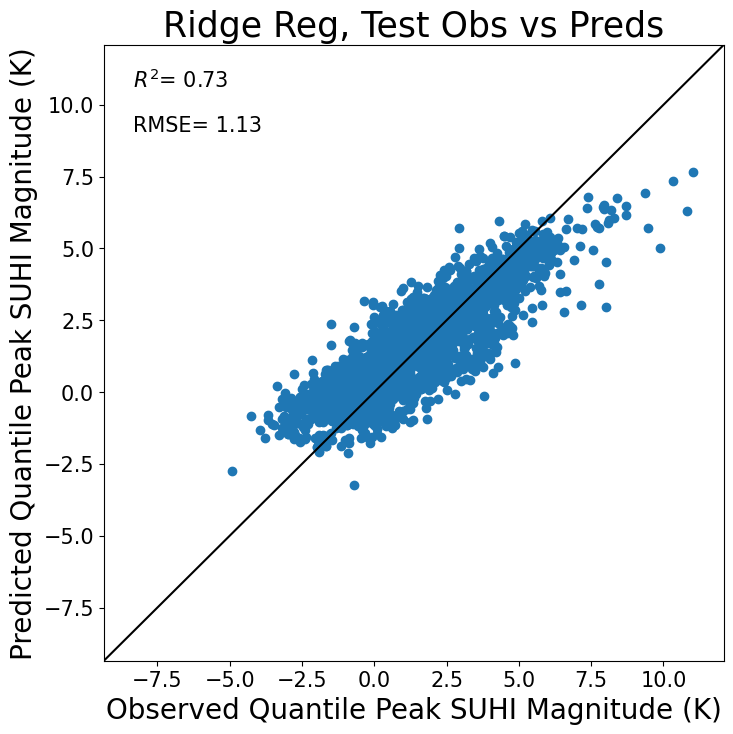

In [10]:
fig, axes = plt.subplots(1,1, figsize = (8, 8))

axes.scatter(y_test, y_test_pred)
axes.set(title = 'Ridge Reg, Test Obs vs Preds', 
         xlabel = 'Observed Quantile Peak SUHI Magnitude (K)', ylabel = 'Predicted Quantile Peak SUHI Magnitude (K)')
#GSA Peak 
axesmin = min(min(y_train), min(y_train_pred)) - 1
axesmax = max(max(y_train), max(y_train_pred)) + 1

axes.set_xlim([axesmin, axesmax])
axes.set_ylim([axesmin, axesmax])

axes.plot([axesmin, axesmax],[axesmin, axesmax], color = 'k')

axes.text(axesmin+1, axesmax-1.5, r'$R^2$= {}'.format(round(test_ridge_r2, 2)), fontsize=15)
axes.text(axesmin+1, axesmax-3, 'RMSE= {}'.format(round(test_ridge_rmse, 2)), fontsize=15)

#axes.text(-7, 10, r'$R^2$= {}'.format(round(train_ridge_r2, 2)), fontsize=15)
#axes.text(-7, 8, 'RMSE= {}'.format(round(train_ridge_rmse, 2)), fontsize=15)


#save figure as png
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT','Graphs_outputs','pred_modelling'))   
plt.savefig('ridger_test_{}.png'.format(overpass_file_name), bbox_inches = 'tight')

In [944]:
############################################
########## R SQUARE PLOTS BY CITY ##########
############################################

######## RR REGRESSION #################

######## MAKE SURE THE RIDGE REGRESSION MODEL HAS BEEN FIT BEFORE RUNNING THIS ##############################
plt.rc('legend', fontsize=10)    # legend fontsize
#loop through each city to generate a r-square value based on the model 
cities = CITY_COUNTRY_lat_lon.City.values

r2_list = []
mean_pred_diff_list = []
rmse_list = []
#annual_mean_SUHI_PEAK_GSA_list = []
annual_mean_SUHI_MEAN_list = []
scaler = StandardScaler()

X_train_poly_norm = pd.DataFrame(scaler.fit_transform(X_train_poly), columns = X_train_poly.columns) #fit and transform
#X_train_norm = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns) #fit and transform

for i, city in enumerate(cities):
    data_city = all_monthly_data_df2[((all_monthly_data_df2['City'] == city) 
                                    & (all_monthly_data_df2['Overpass'] == overpass_time))].copy()

    X_data_city = data_city[predictor_variables]                                          #predictors

    # get polynomail terms and interactions
    X_city_poly = pd.DataFrame(poly.fit_transform(X_data_city), columns = poly.get_feature_names_out(X_data_city.columns))
    X_city_poly = X_city_poly.drop('1', axis=1)
    
    #create normalised datasets
    X_city_norm = pd.DataFrame(scaler.transform(X_city_poly), columns = X_city_poly.columns)      #transform only
    #X_city_norm = pd.DataFrame(scaler.transform(X_data_city), columns = X_data_city.columns)      #transform only
    
    y_data_city = data_city[target_variable]                                                      #target
    
    y_city_pred = RR_model.predict(X_city_norm)
    
    r2_score_city = r2_score(y_data_city, y_city_pred)                                            #predict the r2 score
    mean_pred_diff = abs(y_city_pred - y_data_city).mean()
    rmse_city = np.sqrt(mean_squared_error(y_data_city, y_city_pred))
    annual_mean_SUHI_MEAN = y_data_city.mean()
    
    r2_list.append(r2_score_city)
    mean_pred_diff_list.append(mean_pred_diff)
    rmse_list.append(rmse_city)
    annual_mean_SUHI_MEAN_list.append(annual_mean_SUHI_MEAN)
    
    # create a plot of the actual vs predicted
    fig, axes = plt.subplots(1,1, figsize = (8, 8))

    axes.scatter(y_data_city, y_city_pred)
    axes.set(title = '{} Ridge Reg, Test {}'.format(city, overpass_time), 
         xlabel = 'Observed Mean SUHI Magnitude (K)', ylabel = 'Predicted Mean SUHI Magnitude (K)')

    axesmin = min(min(y_data_city), min(y_city_pred)) - 1
    axesmax = max(max(y_data_city), max(y_city_pred)) + 1

    axes.set_xlim([axesmin, axesmax])
    axes.set_ylim([axesmin, axesmax])

    axes.plot([axesmin, axesmax],[axesmin, axesmax], color = 'k')

    axes.text(0,1, r'$R^2$= {}'.format(round(r2_score_city, 2)), fontsize=15, horizontalalignment='center',
     verticalalignment='center', transform=ax.transAxes)
    axes.text(0,0.9, 'RMSE= {}'.format(round(rmse_city, 2)), fontsize=15,horizontalalignment='center',
     verticalalignment='center', transform=ax.transAxes)

    #save figure as png
    if overpass_time == '13:30':
        os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts','PROJECT','MEAN_SUHI','City_Scatters'))   
        plt.savefig('{}_obvs_vs_preds_13_30.png'.format(city), bbox_inches = 'tight')    
    else:
        os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts','PROJECT','MEAN_SUHI','City_Scatters','0130'))   
        plt.savefig('{}_obvs_vs_preds_01_30.png'.format(city), bbox_inches = 'tight')    
    
    plt.close()
    
    SUHI_MEAN = list(all_monthly_data_df[(all_monthly_data_df['Overpass']== overpass_time)&(all_monthly_data_df['City']== city
                                                            )].groupby(['month']).mean(numeric_only = True).SUHI_MEAN)

    SUHI_MEAN_STD = list(all_monthly_data_df[(all_monthly_data_df['Overpass']== overpass_time)&(all_monthly_data_df['City']== city
                                                            )].groupby(['month']).std(numeric_only = True).SUHI_MEAN)
    
    data_temp = all_monthly_data_df3[((all_monthly_data_df3['City'] == city) 
                                    & (all_monthly_data_df3['Overpass'] == overpass_time))].copy()
    data_temp['SUHI_MEAN_PRED'] = y_city_pred
    
    SUHI_MEAN_PRED = list(data_temp[(data_temp['Overpass']== overpass_time)&(data_temp['City']== city
                                                     )].groupby(['month']).mean(numeric_only = True).SUHI_MEAN_PRED) 
    
    SUHI_MEAN_PRED_STD = list(data_temp[(data_temp['Overpass']== overpass_time)&(data_temp['City']== city
                                                      )].groupby(['month']).std(numeric_only = True).SUHI_MEAN_PRED) 
    
    EVI_U = list(all_monthly_data_df[(all_monthly_data_df['Overpass']== overpass_time)&(all_monthly_data_df['City']== city
                                                       )].groupby(['month']).mean(numeric_only = True).EVI_U)
    EVI_U_STD = list(all_monthly_data_df[(all_monthly_data_df['Overpass']== overpass_time)&(all_monthly_data_df['City']== city
                                                       )].groupby(['month']).std(numeric_only = True).EVI_U)

    
    #check for/ insert missing months as nans
    mons = list(set(all_monthly_data_df[(all_monthly_data_df['Overpass']== overpass_time)&(all_monthly_data_df['City']== city
                                                                        )].month))
    all_months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
    if len(SUHI_MEAN) != 12:
        # find which is the missing month and add it into the df with nan values
        missing_month = [i for i in all_months if i not in mons]
        SUHI_MEAN.insert(missing_month[0],np.nan)
        SUHI_MEAN_STD.insert(missing_month[0],np.nan)
        SUHI_MEAN_PRED.insert(missing_month[0],np.nan)
        SUHI_MEAN_PRED_STD.insert(missing_month[0],np.nan)
        EVI_U.insert(missing_month[0],np.nan)
        EVI_U_STD.insert(missing_month[0],np.nan)
        
    fig, axes = plt.subplots(nrows = 1,ncols = 1, figsize=(8, 8))
    
    axes.errorbar(x = range(1,13), y = SUHI_MEAN, yerr = SUHI_MEAN_STD, label = 'Observation')
    axes.errorbar(x = range(1,13), y = SUHI_MEAN_PRED, yerr = SUHI_MEAN_PRED_STD, label = 'RR Prediction')
    axes.set_title('{} SUHI Mean Magnitude {}'.format(city,overpass_time))
    axes.set(xlabel = 'Month', ylabel = 'SUHI Mean Magnitude (K)')
    axes.legend()
    
    #axes[0].errorbar(x = range(1,13), y = SUHI_MEAN, yerr = SUHI_MEAN_STD, label = 'Observation')
    #axes[0].errorbar(x = range(1,13), y = SUHI_MEAN_PRED, yerr = SUHI_MEAN_PRED_STD, label = 'RR Prediction')
    #axes[0].set_title('{} SUHI Mean Magnitude 13:30'.format(city))
    #axes[0].set(xlabel = 'Month', ylabel = 'SUHI Mean Magnitude (K)')
    #axes[0].legend()
    
    #axes[1].errorbar(x = range(1,13), y = EVI_U, yerr = EVI_U_STD)
    #axes[1].set_title('{} Urban EVI'.format(city))
    #axes[1].set(xlabel = 'Month', ylabel = 'Urban EVI')

    #save figure as png
    os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts','PROJECT','MEAN_SUHI','Seasonal_cycles_RR_preds_EVI_U'))   
    plt.savefig('{}_{}_seasonal_cycle_with_pred_EVI_U.png'.format(overpass_file_name, city), bbox_inches = 'tight')

    #save to test folder if in test dataset
    if city in test_cities:
        os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts','PROJECT','MEAN_SUHI','Seasonal_cycles_RR_preds_EVI_U'
                             ,'TEST_CITIES'))   
        plt.savefig('{}_{}_seasonal_cycle_with_pred_EVI_U_TEST_CITY.png'.format(overpass_file_name,city), bbox_inches = 'tight')
        
    plt.close()        
#create dataframe
#kg = CITY_COUNTRY_lat_lon.koppen_climate.values

#r2_df = pd.DataFrame({'city': cities, 'r2':r2_list, 'Koppen_Geiger':kg})    
r2_df = pd.DataFrame({'city': cities, 'r2':r2_list, 'mean_pred_diff':mean_pred_diff_list, 'rmse':rmse_list,
                     'annual_mean_SUHI_MEAN':annual_mean_SUHI_MEAN_list})    
print('r2<0', len(r2_df[r2_df['r2'] < 0]))

r2<0 63


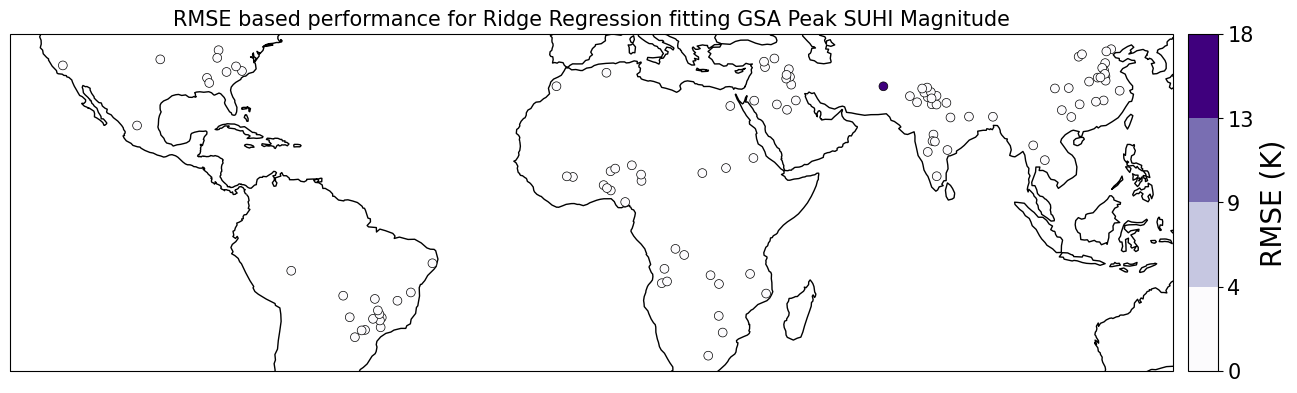

In [389]:
# Plot showing the RMSE for the individual cities

#plt.rc('font', size=35)          # controls default text sizes
plt.rc('axes', titlesize=15)     # fontsize of the axes title

scale_min = 0
scale_max = round((r2_df.rmse).max() + 0.5)

# create the custom colormap so the values are discrete
cmap = plt.cm.Purples  # define the colormap
# extract all colors from the map
cmaplist = [cmap(i) for i in range(cmap.N)]

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.round(np.linspace(scale_min, scale_max, 5),2)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection=ccrs.PlateCarree(), 
              title='RMSE based performance for Ridge Regression fitting GSA Peak SUHI Magnitude')
ax.coastlines()

city_lats = CITY_COUNTRY_lat_lon.Lat.values
city_lons = CITY_COUNTRY_lat_lon.Lon.values
rmse = r2_df.rmse

im = ax.scatter(city_lons, city_lats, zorder=5, c= rmse, linewidths = 0.5, s =40,edgecolor = 'black',
               cmap= cmap, norm=norm)

#get size and extent of axes:
axpos = ax.get_position()
pos_x = axpos.x0 + axpos.width + 0.01 #+ 0.25*axpos.width
pos_y = axpos.y0  
cax_width = 0.02
cax_height = axpos.height
#create new axes where the colorbar should go.
#it should be next to the original axes and have the same height
pos_cax = fig.add_axes([pos_x,pos_y,cax_width,cax_height])

cbar = plt.colorbar(im, cax=pos_cax, label = 'RMSE (K)', cmap= cmap, norm=norm
             ,spacing='proportional', ticks=bounds, boundaries=bounds, format='%1i')

#cbar.ax.yaxis.set_major_formatter(ScalarFormatter())

#save figure as png
#os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT','Chapter_4','figs'))   
#plt.savefig('SSR_annual.png', bbox_inches = 'tight')    ax.scatter(lon, lat, zorder=5,color= point_col, linewidths = point_size)


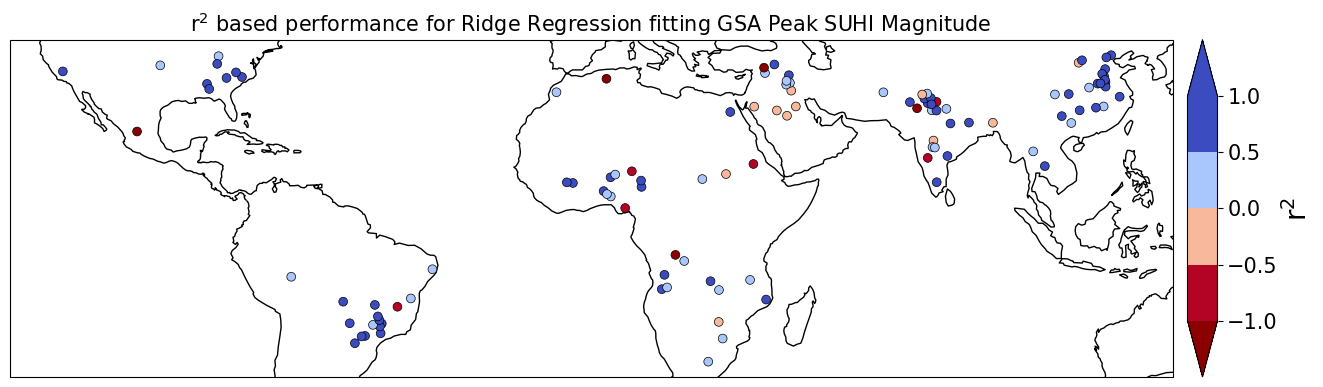

In [46]:
#Display cities with magnitude of incorrect prediction proportional dot
#plot of where the test and training cities are located
#plt.rc('font', size=35)          # controls default text sizes
plt.rc('axes', titlesize=15)     # fontsize of the axes title

scale_min = -2
scale_max = 1

# create the custom colormap so the values are discrete
cmap = plt.cm.coolwarm_r  # define the colormap
# extract all colors from the map
cmaplist = [cmap(i) for i in range(cmap.N)]

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N).with_extremes(under='darkred')

# define the bins and normalize
bounds = [-1,-0.5,0,0.5,1]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)


fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection=ccrs.PlateCarree(), 
              title='r$^2$ based performance for Ridge Regression fitting GSA Peak SUHI Magnitude')
ax.coastlines()

city_lats = CITY_COUNTRY_lat_lon.Lat.values
city_lons = CITY_COUNTRY_lat_lon.Lon.values
r2 = r2_df.r2

im = ax.scatter(city_lons, city_lats, zorder=5, c= r2, linewidths = 0.5, s =40,edgecolor = 'black',
               cmap= cmap, norm=norm)

#get size and extent of axes:
axpos = ax.get_position()
pos_x = axpos.x0 + axpos.width + 0.01 #+ 0.25*axpos.width
pos_y = axpos.y0  
cax_width = 0.02
cax_height = axpos.height
#create new axes where the colorbar should go.
#it should be next to the original axes and have the same height
pos_cax = fig.add_axes([pos_x,pos_y,cax_width,cax_height])

cbar = plt.colorbar(im, cax=pos_cax, label = 'r$^2$', cmap= cmap#, norm = norm
             ,spacing='proportional', ticks=bounds,  format='%1i',boundaries=bounds,extend = 'both',extendfrac='auto')


cbar.ax.yaxis.set_major_formatter(ScalarFormatter())

#save figure as png
#os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT','Chapter_4','figs'))   
#plt.savefig('SSR_annual.png', bbox_inches = 'tight')    ax.scatter(lon, lat, zorder=5,color= point_col, linewidths = point_size)


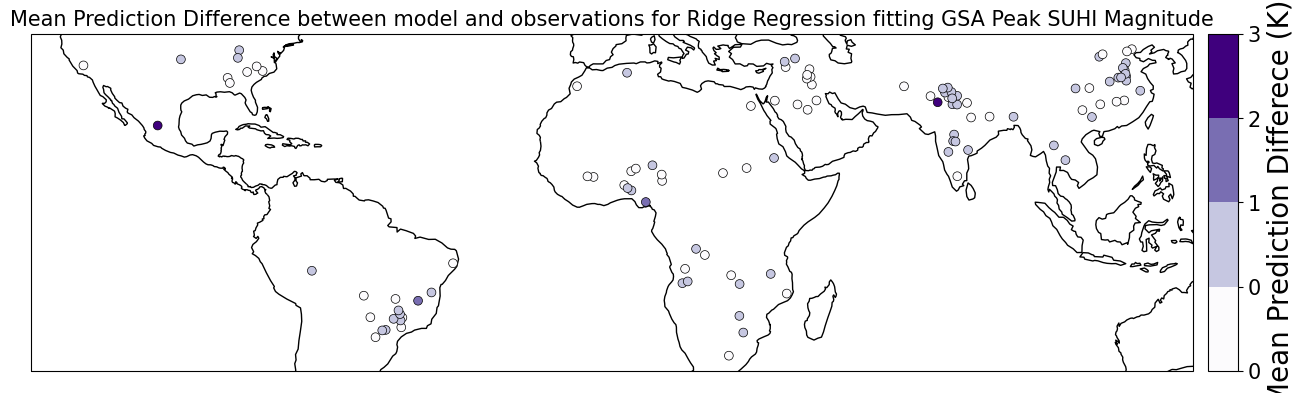

In [47]:
# Plot showing the mean prediction difference for the individual cities

#plt.rc('font', size=35)          # controls default text sizes
plt.rc('axes', titlesize=15)     # fontsize of the axes title

scale_min = 0
scale_max = round((r2_df.mean_pred_diff).max() + 0.5)

# create the custom colormap so the values are discrete
cmap = plt.cm.Purples  # define the colormap
# extract all colors from the map
cmaplist = [cmap(i) for i in range(cmap.N)]

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.round(np.linspace(scale_min, scale_max, 5),2)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection=ccrs.PlateCarree(), 
              title='Mean Prediction Difference between model and observations for Ridge Regression fitting GSA Peak SUHI Magnitude')
ax.coastlines()

city_lats = CITY_COUNTRY_lat_lon.Lat.values
city_lons = CITY_COUNTRY_lat_lon.Lon.values
mean_pred_diff = r2_df.mean_pred_diff

im = ax.scatter(city_lons, city_lats, zorder=5, c= mean_pred_diff, linewidths = 0.5, s =40,edgecolor = 'black',
               cmap= cmap, norm=norm)

#get size and extent of axes:
axpos = ax.get_position()
pos_x = axpos.x0 + axpos.width + 0.01 #+ 0.25*axpos.width
pos_y = axpos.y0  
cax_width = 0.02
cax_height = axpos.height
#create new axes where the colorbar should go.
#it should be next to the original axes and have the same height
pos_cax = fig.add_axes([pos_x,pos_y,cax_width,cax_height])

cbar = plt.colorbar(im, cax=pos_cax, label = 'Mean Prediction Differece (K)', cmap= cmap, norm=norm
             ,spacing='proportional', ticks=bounds, boundaries=bounds, format='%1i')

#cbar.ax.yaxis.set_major_formatter(ScalarFormatter())

#save figure as png
#os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT','Chapter_4','figs'))   
#plt.savefig('SSR_annual.png', bbox_inches = 'tight')    ax.scatter(lon, lat, zorder=5,color= point_col, linewidths = point_size)


In [ ]:
############################################
#### PERMUTATIONS OF RIDGE REGRESSIONS ####
############################################

#RR to test all permutations of predictor variables
#create a dataframe to fill
predictor_variables = X_train_norm.columns.values

n = len(predictor_variables)
whole_grid = np.ones((1, n), dtype=int) #start with the case where all variables are included

for i in range(n-1):
    m = i+1
    which = np.array(list(itertools.combinations(range(n), m)))
    grid = np.zeros((len(which), n), dtype="int8")

    #add the combinations into the grid
    grid[np.arange(len(which))[None].T, which] = 1

    whole_grid = np.vstack((whole_grid, grid))
    
all_models = pd.DataFrame(data = whole_grid, columns = predictor_variables) #create a dataframe with all the combinations
#add in the test statistics
all_models['train_rmse'] = np.nan
all_models['train_rsquared'] = np.nan
all_models['test_rmse'] = np.nan
all_models['test_rsquared'] = np.nan

# Define the ridge reg model/ cross validation
folds = 5    #define the number of folds (K)

#define regression model
ridge_reg = Ridge(fit_intercept=True)
#specify the hyperparameters to test
hyper_params = {'alpha':[0,1e-25,1e-15,1e-10,1e-5,1, 10, 50, 100, 400,500,600, 10000]}
#use cross validation to determine the hyperparameter value
model_cv = GridSearchCV(estimator = ridge_reg, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True) 


#go through the table and calculate test statistics for models including combinations of pred variables
for i in range(len(all_models)):
    row = all_models.iloc[i] #take the row
    variable_list = []
    for p, predictor in enumerate(predictor_variables):
        if row[p] == 1:
            variable_list.append(predictor)                #create list of the variables which are used in the row
    
    X_train_temp = X_train_norm[variable_list]             #select the train variables to be used
    X_test_temp = X_test_norm[variable_list]
    
    # get polynomail terms and interactions
    poly = PolynomialFeatures(2)
    X_train_temp_poly = pd.DataFrame(poly.fit_transform(X_train_temp), columns = poly.get_feature_names_out(X_train_temp.columns))
    X_train_temp_poly = X_train_temp_poly.drop('1', axis=1)

    X_test_temp_poly = pd.DataFrame(poly.fit_transform(X_test_temp), columns = poly.get_feature_names_out(X_test_temp.columns))
    X_test_temp_poly = X_test_temp_poly.drop('1', axis=1)

    #not using test data for model validation/ selection as it must remain untouched
    #carry out the ridge regression    
    #fit the model
    model_cv.fit(X_train_temp_poly, y_train)  
    #predict training obs
    y_train_pred = model_cv.predict(X_train_temp_poly)

    #calculate the y test prediction
    y_test_pred = model_cv.predict(X_test_temp_poly)              #predict the test dataset
    
    #add in the test statistics
    all_models.loc[i,'train_rmse'] = rmse(y_train, y_train_pred)                 #train rmse
    all_models.loc[i,'train_rsquared'] = r2_score(y_train, y_train_pred)         #train r square
    all_models.loc[i,'test_rmse'] = rmse(y_test, y_test_pred)                    #test rmse
    all_models.loc[i,'test_rsquared'] = r2_score(y_test, y_test_pred)            #test r square
    
    
#save the table as a pickle
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT','UHI_Project_Pickle_Files','predictive_models')) 
with open('variables_poly_interactions_ridge_reg.pkl', 'wb') as f:
    pickle.dump(all_models, f)

#for each number of predictor variables, select the model with the best r-squared
#add in the number of variables used in each model
all_models['num_variables'] = all_models[predictor_variables].sum(axis = 1)

#create empty dataframe to be filled
best_models = pd.DataFrame()
#select the models for each variable which have the best r-square
#best_models 
for i in range(len(predictor_variables)):
    max_rsquare = max(all_models[all_models['num_variables'] == (i+1)].train_rsquared)
    rows = all_models[(all_models['train_rsquared'] == max_rsquare)& (all_models['num_variables'] == (i+1))]
    best_models = pd.concat([best_models, rows])

In [ ]:
all_models 

In [ ]:
#plot the number of variables against the r-squared and rmse
fig, axes = plt.subplots(1,2, figsize = (20, 5))
axes[0].plot(best_models.num_variables, best_models.train_rsquared, label = 'Train')
axes[0].plot(best_models.num_variables, best_models.test_rsquared, label = 'Test')
axes[0].set(xlabel = 'Number of Variables', ylabel = 'R-Squared', title = 'R-Squared')
axes[0].legend()

axes[1].plot(best_models.num_variables, best_models.train_rmse, label = 'Train')
axes[1].plot(best_models.num_variables, best_models.test_rmse, label = 'Test')
axes[1].set(xlabel = 'Number of Variables', ylabel = 'RMSE', title = 'RMSE')
axes[1].legend()

xa = axes[0].get_xaxis()
xa.set_major_locator(MaxNLocator(integer=True))
xa = axes[1].get_xaxis()
xa.set_major_locator(MaxNLocator(integer=True))

In [ ]:
best_models

Muliple Linear Regression

In [ ]:
#Multiple Linear Regression (MLR) (degree 1 (not polynomial))

##################################
####### Creating the model #######
##################################
#Create linear regression object
lin_reg = LinearRegression()

#fit the model
lin_reg.fit(X_train_norm, y_train)

#predict the training 
y_train_pred = lin_reg.predict(X_train_norm)
#predict the test
y_test_pred = lin_reg.predict(X_test_norm)

#intercept
lin_intercept = lin_reg.intercept_
print('Intercept -- ',lin_intercept)
#coefficients
lin_coef = lin_reg.coef_
print('Coefficients--')
for i in range(len(lin_coef)):
    print(predictor_variables[i],':', lin_coef[i])

######################################################
###### Performance Metrics for the training set ######
######################################################
#rmse
train_lin_mse = mean_squared_error(y_train, y_train_pred)
train_lin_rmse = np.sqrt(train_lin_mse)
#r-square
train_lin_r2 = r2_score(y_train, y_train_pred)
#mae
train_lin_mae = mean_absolute_error(y_train, y_train_pred)
print('Training Metrics--', 'RMSE:', train_lin_rmse, 'R-square:', train_lin_r2, 'MAE:', train_lin_mae)

#################################################
###### Performance Metrics for the test set #####
#################################################
#rmse
test_lin_mse = mean_squared_error(y_test, y_test_pred)
test_lin_rmse = np.sqrt(test_lin_mse)
#r-square
test_lin_r2 = r2_score(y_test, y_test_pred)
#mae
test_lin_mae = mean_absolute_error(y_test, y_test_pred)
print('Test Metrics--', 'RMSE:', test_lin_rmse, 'R-square:', test_lin_r2, 'MAE:', test_lin_mae)

In [ ]:
#Multiple Linear Regression (MLR) (degree 1 (not polynomial))

##################################
##### SUMMARY STATISTICS #########
##################################
#Carried out again in stats models library to get the p-values (no function to calculate these in scikit learn)
X_train1 = X_train_norm.to_numpy()     #required form of X is an array
X_train2 = sm.add_constant(X_train1)   #add intercept to model
est = sm.OLS(y_train, X_train2)
est2 = est.fit()
print(est2.summary())

In [ ]:
############################################
########## R SQUARE PLOTS BY CITY ##########
############################################

######## LINEAR REGRESSION #################

######## MAKE SURE THE  LINEAR REGRESSION MODEL HAS BEEN FIT BEFORE RUNNING THIS ##############################

#loop through each city to generate a r-square value based on the model 
cities = CITY_COUNTRY_lat_lon.City.values

r2_list = []

#set the transformer (transform based on all cities not just one)
X_train_norm = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)         #fit and transform

for i, city in enumerate(cities):
    data_city = all_monthly_data_df2[((all_monthly_data_df2['City'] == city) 
                                    & (all_monthly_data_df2['Overpass'] == overpass_time))].copy()

    X_data_city = data_city[predictor_variables]                                                  #predictors
    X_data_city_norm = pd.DataFrame(scaler.transform(X_data_city), columns = X_data_city.columns) #transform only
    y_data_city = data_city[target_variable]                                                      #target
    
    y_city_pred = lin_reg.predict(X_data_city_norm)
    
    r2_score_city = r2_score(y_data_city, y_city_pred)                                            #predict the r2 score
    
    r2_list.append(r2_score_city)

#create dataframe
#kg = CITY_COUNTRY_lat_lon.koppen_climate.values

#r2_df = pd.DataFrame({'city': cities, 'r2':r2_list, 'Koppen_Geiger':kg})    
r2_df = pd.DataFrame({'city': cities, 'r2':r2_list})    
print('r2<0', len(r2_df[r2_df['r2'] < 0]))

In [ ]:
r2_df[r2_df['r2'] < 0]

In [ ]:
#Display cities with r2 proportional dot
#plot of where the test and training cities are located
fig = plt.figure(figsize=(40,35))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

for i, city in enumerate(cities):

    lat = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['City'] == city]['Lat']
    lon = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['City'] == city]['Lon']
    r2 = r2_df.iloc[i].r2
        
    if r2 > -1:
        point_size = 15*abs(r2)
    else:
        point_size = 15
    
    if r2 < 0:
        point_col = 'red'
    else:
        point_col = 'blue'
    
    ax.scatter(lon, lat, zorder=5,color= point_col, linewidths = point_size)

    
    
legend_elements = [Line2D([0],[0],marker='o', color = 'w', markerfacecolor='blue', label = 'Positive R-Square'
                          , markersize=15),Line2D([0],[0],marker='o', color = 'w', markerfacecolor='red'
                          , label = 'Negative R-Square' , markersize=15)]
ax.legend(handles = legend_elements, loc=2, borderpad = 1, fontsize = 35, labelspacing=0.8)                          

In [ ]:
#plot the number of variables against the r-squared, AIC and rmse
fig, axes = plt.subplots(1,2, figsize = (20, 5))
axes[0].plot(best_models.num_variables, best_models.rsquared, label = 'Train')
axes[0].plot(best_models.num_variables, best_models.test_rsquared, label = 'Test')
axes[0].set(xlabel = 'Number of Variables', ylabel = 'R-Squared', title = 'R-Squared')
axes[0].legend()

axes[1].plot(best_models.num_variables, best_models.rmse, label = 'Train')
axes[1].plot(best_models.num_variables, best_models.test_rmse, label = 'Test')
axes[1].set(xlabel = 'Number of Variables', ylabel = 'RMSE', title = 'RMSE')
axes[1].legend()

xa = axes[0].get_xaxis()
xa.set_major_locator(MaxNLocator(integer=True))
xa = axes[1].get_xaxis()
xa.set_major_locator(MaxNLocator(integer=True))

In [ ]:
best_models

In [ ]:
best_models.iloc[5]

In [ ]:
all_models[(all_models['num_variables'] == 6)&(all_models['rural_ssr'] == 1)&(all_models['rur_mean_evi'] == 1)
          &(all_models['evi_diff'] == 1)&(all_models['log_area_x_rur_ef'] == 1)&(all_models['Eccentricity'] == 1)
          &(all_models['rural_evap_fract'] == 1)]

In [ ]:
#Using cross validation to determine the number of variables used (the hyperparameter in this case)
n = len(predictor_variables) 
#cross-validation scheme, 5 fold
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

#specify range of hyperparameters to tune
hyper_params = [{'n_features_to_select': list(range(1, n+1))}]

#perform grid search

lin_reg = LinearRegression()           #specify model
lin_reg.fit(X_train_norm, y_train)     #fit the model 
rfe = RFE(lin_reg)                     #feature selection

#Use cross validation
model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train_norm, y_train)  

#cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results


In [ ]:
model_cv.best_params_

In [ ]:
# plotting cv results
fig, axes = plt.subplots(1,1, figsize = (16, 6))

axes.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
axes.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
axes.set(xlabel= 'number of features', ylabel='r-squared', title = "Optimal Number of Features")
axes.legend(['test score', 'train score'], loc='upper left')
xa = axes.get_xaxis()
xa.set_major_locator(MaxNLocator(integer=True))

In [ ]:
#Multiple Linear Regression (MLR) (degree 2 (polynomial))
##################################
####### Creating the model #######
##################################

#create polynomial inputs, 
poly_features = PolynomialFeatures(degree = 2)
X_poly = poly_features.fit_transform(X_train_norm)

#create the lin reg model
lin_reg = LinearRegression()

#then feed polynomials to lin reg model
lin_reg.fit(X_poly, y_train)
#predict the training 
y_train_pred = lin_reg.predict(X_poly)
#predict the test
X_poly_test = poly_features.fit_transform(X_test_norm)
y_test_pred = lin_reg.predict(X_poly_test)

#intercept
lin_intercept = lin_reg.intercept_
print('Intercept -- ',lin_intercept)
#coefficients
poly_predictor_vars = poly_features.get_feature_names(predictor_variables)
lin_coef = lin_reg.coef_
print('Coefficients--')
for i in range(len(lin_coef)):
    print(poly_predictor_vars[i],':',lin_coef[i])

######################################################
###### Performance Metrics for the training set ######
######################################################
#rmse
train_lin_mse = mean_squared_error(y_train, y_train_pred)
train_lin_rmse = np.sqrt(train_lin_mse)
#r-square
train_lin_r2 = r2_score(y_train, y_train_pred)
#mae
train_lin_mae = mean_absolute_error(y_train, y_train_pred)
print('Training Metrics--', 'RMSE:', train_lin_rmse, 'R-square:', train_lin_r2, 'MAE:', train_lin_mae)

#################################################
###### Performance Metrics for the test set #####
#################################################
#rmse
test_lin_mse = mean_squared_error(y_test, y_test_pred)
test_lin_rmse = np.sqrt(test_lin_mse)
#r-square
test_lin_r2 = r2_score(y_test, y_test_pred)
#mae
test_lin_mae = mean_absolute_error(y_test, y_test_pred)
print('Test Metrics--', 'RMSE:', test_lin_rmse, 'R-square:', test_lin_r2, 'MAE:', test_lin_mae)

Random Forest regression (RFR)

In [27]:
##################################
#### RANDOM FOREST REGRESSION ####
##################################

forest_reg = RandomForestRegressor()                                  #define the model

#carry out cross validation
folds = 5                                                             #define the number of folds (K)
#specify the hyperparameters to test
#num_features_for_split = total_input_features/3
hyper_params = {'n_estimators':[100,200]                              #the number of trees
                ,'max_depth':[10,20,30,40,50,60,70,80,90,100,None]    #the tree depth
                ,'min_samples_leaf':[1,2,4,15]                        #min number of samples required at each leaf node
                ,'min_samples_split':[2,5,10,15] }                    #min number of samples required to split a node

#use cross validation to determine the hyperparameter value
model_cv = GridSearchCV(estimator = forest_reg, 
                        param_grid = hyper_params, 
                        #scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,                                  #verbose- how detailed output is   
                        return_train_score=True) 
#fit the model
model_cv.fit(X_train_norm, y_train)  

#cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

Fitting 5 folds for each of 352 candidates, totalling 1760 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,7.356845,0.791459,0.048271,0.005046,10,1,2,100,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_...",0.734123,...,0.674181,0.058804,269,0.922239,0.918233,0.934896,0.937914,0.924921,0.927641,0.007527
1,13.341562,0.152716,0.082501,0.017664,10,1,2,200,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_...",0.727314,...,0.673148,0.058271,305,0.921542,0.918293,0.935363,0.937495,0.925201,0.927579,0.007580
2,7.080932,0.445895,0.044647,0.011807,10,1,5,100,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_...",0.725339,...,0.678604,0.058851,136,0.919316,0.916382,0.933680,0.936109,0.923496,0.925796,0.007803
3,14.536079,0.639980,0.100508,0.013549,10,1,5,200,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_...",0.730463,...,0.671540,0.057947,327,0.919854,0.917160,0.933827,0.936773,0.923770,0.926277,0.007718
4,6.918889,0.225543,0.037943,0.008237,10,1,10,100,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_...",0.728969,...,0.675816,0.056580,219,0.916434,0.913638,0.931243,0.933461,0.920267,0.923009,0.007945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,13.097725,0.108840,0.074983,0.006249,None,15,5,200,"{'max_depth': None, 'min_samples_leaf': 15, 'm...",0.737259,...,0.690014,0.057680,58,0.908296,0.900339,0.923154,0.922659,0.911022,0.913094,0.008749
348,6.515225,0.106714,0.040599,0.007655,None,15,10,100,"{'max_depth': None, 'min_samples_leaf': 15, 'm...",0.737526,...,0.695227,0.057797,1,0.907706,0.900587,0.923066,0.922364,0.910696,0.912884,0.008676
349,13.091576,0.212515,0.078100,0.000015,None,15,10,200,"{'max_depth': None, 'min_samples_leaf': 15, 'm...",0.737322,...,0.689317,0.059857,69,0.908439,0.900694,0.923034,0.922720,0.911097,0.913197,0.008612
350,6.547110,0.128784,0.034369,0.006247,None,15,15,100,"{'max_depth': None, 'min_samples_leaf': 15, 'm...",0.735181,...,0.688980,0.060101,77,0.908405,0.900429,0.923598,0.921986,0.911250,0.913134,0.008662


In [28]:
cv_results[cv_results['rank_test_score'] < 10].sort_values(by = ['rank_test_score'])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
348,6.515225,0.106714,0.040599,0.007655,None,15,10,100,"{'max_depth': None, 'min_samples_leaf': 15, 'm...",0.737526,...,0.695227,0.057797,1,0.907706,0.900587,0.923066,0.922364,0.910696,0.912884,0.008676
186,6.152019,0.110092,0.035637,0.006121,60,15,5,100,"{'max_depth': 60, 'min_samples_leaf': 15, 'min...",0.734590,...,0.694004,0.059337,2,0.908133,0.900379,0.923116,0.922285,0.910986,0.912980,0.008667
218,6.569151,0.176009,0.043394,0.006461,70,15,5,100,"{'max_depth': 70, 'min_samples_leaf': 15, 'min...",0.738391,...,0.693583,0.059456,3,0.908116,0.900052,0.923242,0.922367,0.911290,0.913013,0.008798
158,6.177089,0.087784,0.036502,0.002238,50,15,15,100,"{'max_depth': 50, 'min_samples_leaf': 15, 'min...",0.740417,...,0.693416,0.061875,4,0.907988,0.900148,0.923680,0.922295,0.910860,0.912994,0.008892
318,6.086423,0.183589,0.034366,0.006243,100,15,15,100,"{'max_depth': 100, 'min_samples_leaf': 15, 'mi...",0.739092,...,0.693070,0.061714,5,0.908370,0.900264,0.923043,0.922560,0.911325,0.913112,0.008702
280,6.103515,0.190812,0.036103,0.002475,90,15,2,100,"{'max_depth': 90, 'min_samples_leaf': 15, 'min...",0.734208,...,0.692957,0.060775,6,0.907799,0.900572,0.923008,0.922077,0.910983,0.912888,0.008580
316,6.088797,0.194914,0.034367,0.006249,100,15,10,100,"{'max_depth': 100, 'min_samples_leaf': 15, 'mi...",0.732707,...,0.692613,0.057943,7,0.907893,0.900466,0.922989,0.922154,0.910954,0.912891,0.008613
24,6.429366,0.231721,0.043739,0.006248,10,15,2,100,"{'max_depth': 10, 'min_samples_leaf': 15, 'min...",0.736672,...,0.692600,0.058246,8,0.896525,0.891099,0.913244,0.914534,0.900791,0.903239,0.009232
62,6.664415,0.163514,0.036824,0.005801,20,15,15,100,"{'max_depth': 20, 'min_samples_leaf': 15, 'min...",0.737868,...,0.692593,0.057945,9,0.908255,0.900561,0.922744,0.922301,0.910969,0.912966,0.008519


In [29]:
#Performance stats for random forest regression
y_train_pred = model_cv.predict(X_train_norm)
y_test_pred = model_cv.predict(X_test_norm)

#####################################################
###### Performance Metrics for the training set ######
######################################################
#rmse
train_forest_mse = mean_squared_error(y_train, y_train_pred)
train_forest_rmse = np.sqrt(train_forest_mse)
#r-square
train_forest_r2 = r2_score(y_train, y_train_pred)
#mae
train_forest_mae = mean_absolute_error(y_train, y_train_pred)
print('Training Metrics--', 'RMSE:', train_forest_rmse, 'R-square:', train_forest_r2, 'MAE:', train_forest_mae)

#################################################
###### Performance Metrics for the test set #####
#################################################
#rmse
test_forest_mse = mean_squared_error(y_test, y_test_pred)
test_forest_rmse = np.sqrt(test_forest_mse)
#r-square
test_forest_r2 = r2_score(y_test, y_test_pred)
#mae
test_forest_mae = mean_absolute_error(y_test, y_test_pred)
print('Test Metrics--', 'RMSE:', test_forest_rmse, 'R-square:', test_forest_r2, 'MAE:', test_forest_mae)


Training Metrics-- RMSE: 0.7285394795650197 R-square: 0.9125604586429409 MAE: 0.5194071289077298
Test Metrics-- RMSE: 1.3309322686208642 R-square: 0.5679220222001642 MAE: 1.0380172583388918


In [30]:
model_cv.best_params_

{'max_depth': None,
 'min_samples_leaf': 15,
 'min_samples_split': 10,
 'n_estimators': 100}

In [31]:
##### FEATURE IMPORTANCE ####

model_n_estimators = model_cv.best_params_['n_estimators']
model_min_split= model_cv.best_params_['min_samples_split']
model_min_leaf = model_cv.best_params_['min_samples_leaf']
model_max_depth = model_cv.best_params_['max_depth']

model = RandomForestRegressor(n_estimators=model_n_estimators, min_samples_leaf=model_min_leaf, 
                              min_samples_split = model_min_split, max_depth = model_max_depth)
model.fit(X_train_norm, y_train)

for name, importance in zip(X_train.columns, model.feature_importances_):
    print (name, ':',importance)

EF : 0.00933838354838126
SSR : 0.03115824589972347
EVI_U : 0.003942313403745936
EVI_R : 0.7577977801966149
EVI_D : 0.03841039871942396
ECC : 0.009389925272935896
LOG_AREA : 0.028118846609986932
ELEVATION_D : 0.03304596832132496
CROPLAND : 0.03750676957479727
GRASSLAND : 0.033496537780577554
WATER : 0.005108072366362376
BARE : 0.012686758306125404


In [34]:
test_cities

['Vitória da Conquista',
 'Tshikapa',
 'Saki',
 'Parakou',
 'Bobo_Dioulasso',
 'Baaqoobah',
 'Asyut',
 'Marrakech',
 'Jalandhar',
 'Linqing',
 'Anshun',
 'Huambo',
 'Lexington-Fayette',
 'Fayetteville',
 'Montgomery',
 'Dayton']

Text(0.5, 0, 'Relative Importance')

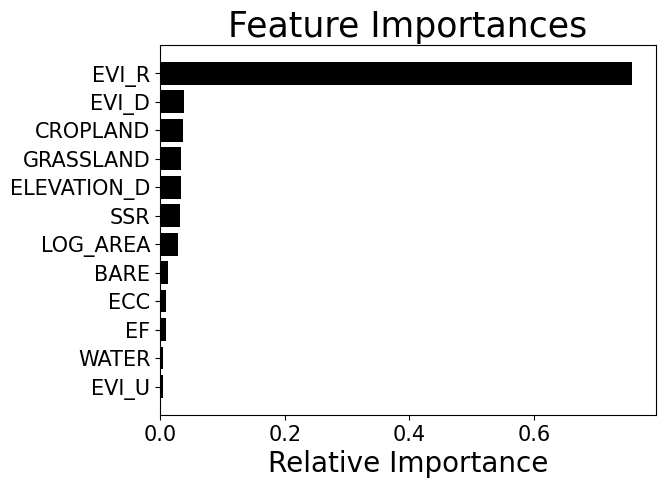

In [32]:
# plot the feature importance #
features = X_train.columns
importances = model.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='k', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')

Text(0.02, 0.9, 'RMSE= 1.33')

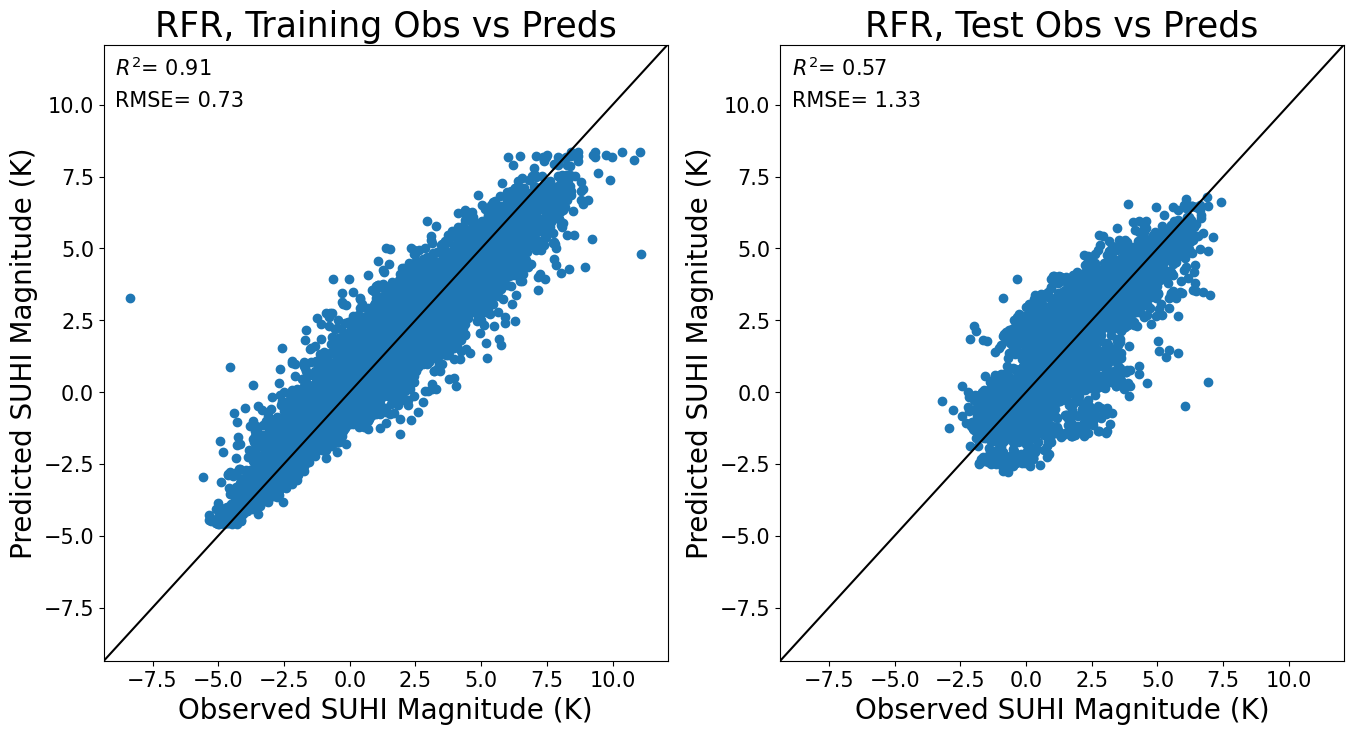

In [33]:
#plots

fig, axes = plt.subplots(1,2, figsize = (16, 8))

axes[0].scatter(y_train, y_train_pred)
axes[0].set(title = 'RFR, Training Obs vs Preds', 
         xlabel = 'Observed SUHI Magnitude (K)', ylabel = 'Predicted SUHI Magnitude (K)')

axesmin = min(min(y_train), min(y_train_pred)) - 1
axesmax = max(max(y_train), max(y_train_pred)) + 1

axes[0].set_xlim([axesmin, axesmax])
axes[0].set_ylim([axesmin, axesmax])

axes[0].plot([axesmin, axesmax],[axesmin, axesmax], color = 'k')

axes[0].text(0.02, 0.95, r'$R^2$= {}'.format(round(train_forest_r2, 2)), fontsize=15, transform=axes[0].transAxes)
axes[0].text(0.02, 0.9, 'RMSE= {}'.format(round(train_forest_rmse, 2)), fontsize=15, transform=axes[0].transAxes)

axes[1].scatter(y_test, y_test_pred)
axes[1].set(title = 'RFR, Test Obs vs Preds', 
         xlabel = 'Observed SUHI Magnitude (K)', ylabel = 'Predicted SUHI Magnitude (K)')

axes[1].set_xlim([axesmin, axesmax])
axes[1].set_ylim([axesmin, axesmax])

axes[1].plot([axesmin, axesmax],[axesmin, axesmax], color = 'k')
axes[1].text(0.02, 0.95, r'$R^2$= {}'.format(round(test_forest_r2, 2)), fontsize=15, transform=axes[1].transAxes)
axes[1].text(0.02, 0.9, 'RMSE= {}'.format(round(test_forest_rmse, 2)), fontsize=15, transform=axes[1].transAxes)


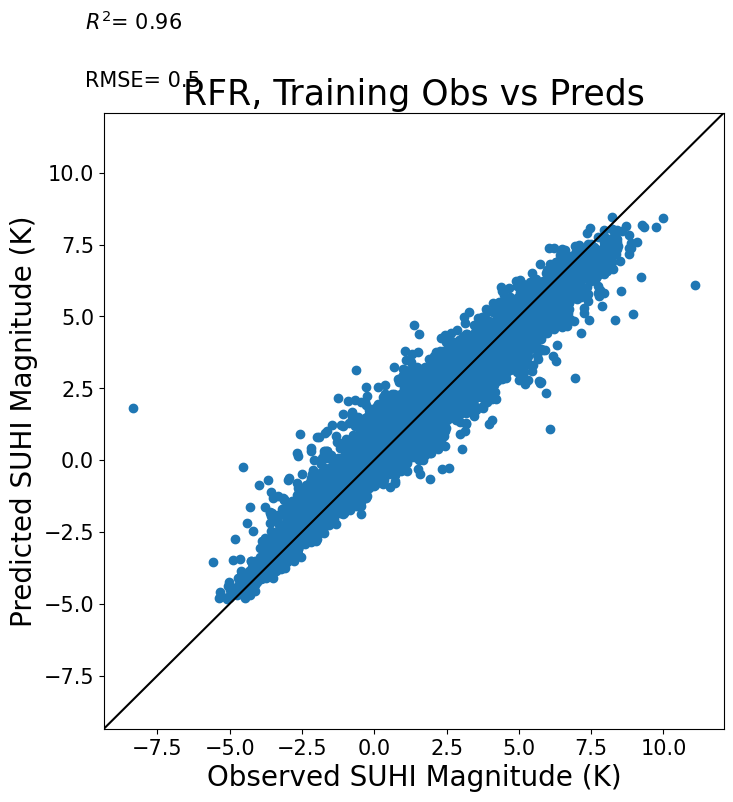

In [18]:
# Plotting 

#plt.rc('font', size=15)          # controls default text sizes
plt.rc('axes', titlesize=25)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
#plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title

fig, axes = plt.subplots(1,1, figsize = (8, 8))
axes.scatter(y_train, y_train_pred)
axes.set(title = 'RFR, Training Obs vs Preds', 
         xlabel = 'Observed SUHI Magnitude (K)', ylabel = 'Predicted SUHI Magnitude (K)')

axesmin = min(min(y_train), min(y_train_pred)) - 1
axesmax = max(max(y_train), max(y_train_pred)) + 1

axes.set_xlim([axesmin, axesmax])
axes.set_ylim([axesmin, axesmax])

axes.plot([axesmin, axesmax],[axesmin, axesmax], color = 'k')

axes.text(0.02, 0.95, r'$R^2$= {}'.format(round(train_forest_r2, 2)), fontsize=15, transform=axes.transAxes)
axes.text(0.02, 0.9, 'RMSE= {}'.format(round(train_forest_rmse, 2)), fontsize=15, transform=axes.transAxes)

#save figure as png
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT','Graphs_outputs','pred_modelling'))   
plt.savefig('rfr_training_2022_09.png', bbox_inches = 'tight')

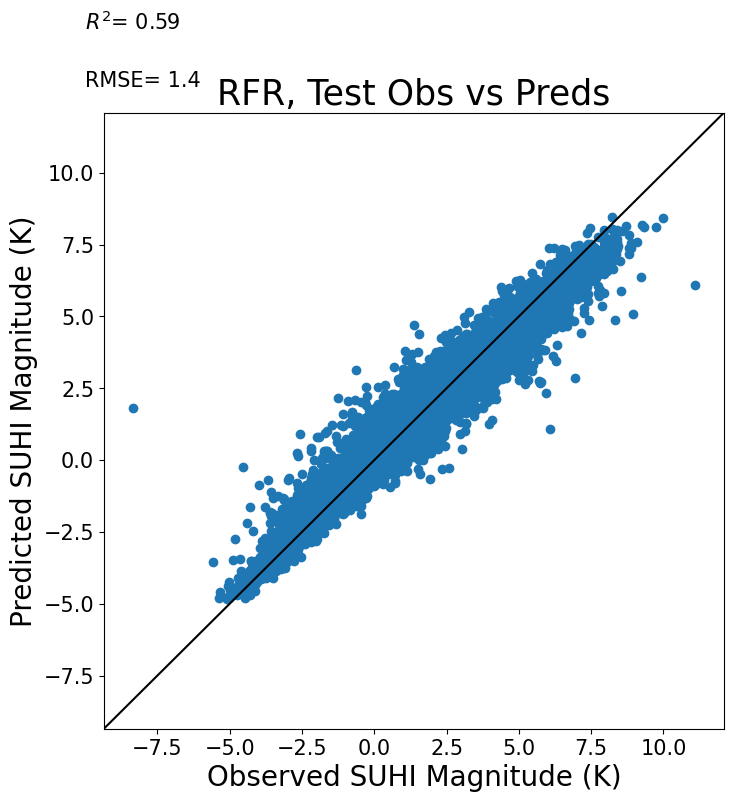

In [19]:
# test dataset 


fig, axes = plt.subplots(1,1, figsize = (8, 8))
axes.scatter(y_train, y_train_pred)
axes.set(title = 'RFR, Test Obs vs Preds', 
         xlabel = 'Observed SUHI Magnitude (K)', ylabel = 'Predicted SUHI Magnitude (K)')

axesmin = min(min(y_train), min(y_train_pred)) - 1
axesmax = max(max(y_train), max(y_train_pred)) + 1

axes.set_xlim([axesmin, axesmax])
axes.set_ylim([axesmin, axesmax])

axes.plot([axesmin, axesmax],[axesmin, axesmax], color = 'k')

axes.text(-10, 15, r'$R^2$= {}'.format(round(test_forest_r2, 2)), fontsize=15)
axes.text(-10, 13, 'RMSE= {}'.format(round(test_forest_rmse, 2)), fontsize=15)

#save figure as png
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT','Graphs_outputs','pred_modelling'))   
plt.savefig('rfr_test_2022_09.png', bbox_inches = 'tight')

Gaussian Process Regression

In [ ]:
#############################################
######## GAUSSIAN PROCESS REGRESSION ########
#############################################

gpr = GaussianProcessRegressor()               # define the model

RBF_kernel = RBF()                             # define the kernels
Dot_Product_kernel = DotProduct()
Matern_kernel = Matern()
#carry out cross validation
folds = 5                                                                       #define the number of folds (K)
#specify the hyperparameters to test

hyper_params = [{'kernel':[RBF_kernel]                # using the RBF kernel
                ,'alpha':[1e-2, 1e-3, 1e-5, 1e-10]    # e-10 is the default alpha (value added to cov matrix diagonal)
                ,'n_restarts_optimizer':[0,20,50]          # number of restarts for the optimizer to find kernels parameters    
            } ,{'kernel':[Dot_Product_kernel]         # using the dot prod kernel
                ,'alpha':[1e-2, 1e-3, 1e-5, 1e-10]    
                ,'n_restarts_optimizer':[0,20,50] 
            }  ,{'kernel':[Matern_kernel]             # using the Matern kernel
                ,'alpha':[1e-2, 1e-3, 1e-5, 1e-10]    
                ,'n_restarts_optimizer':[0,20,50] 
            }]                 


#hyper_params = [{'kernel':[RBF_kernel]                # using the RBF kernel
#                ,'alpha':[1e-2, 1e-3, 1e-5, 1e-10]    # e-10 is the default alpha (value added to cov matrix diagonal)
#                ,'n_restarts_optimizer':[0,20,50]          # number of restarts for the optimizer to find kernels parameters    
#                }]   

#default value for max_iter = 1000
model_cv = GridSearchCV(estimator = gpr, 
                        param_grid = hyper_params, 
                        #scoring= 'r2',                        
                        cv = folds, 
                        verbose = 1,                                  #verbose- how detailed output is   
                        return_train_score=True) 

#fit the model
model_cv.fit(X_train_norm, y_train_norm)  

#cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

In [ ]:
model_cv.best_params_

In [ ]:
#Performance stats for gaussian porcess regression
y_train_pred = model_cv.predict(X_train_norm)
y_test_pred = model_cv.predict(X_test_norm)

#####################################################
###### Performance Metrics for the training set ######
######################################################
#rmse
train_gpr_mse = mean_squared_error(y_train_norm, y_train_pred)
train_gpr_rmse = np.sqrt(train_gpr_mse)
#r-square
train_gpr_r2 = r2_score(y_train_norm, y_train_pred)
#mae
train_gpr_mae = mean_absolute_error(y_train_norm, y_train_pred)
print('Training Metrics--', 'RMSE:', train_gpr_rmse, 'R-square:', train_gpr_r2, 'MAE:', train_gpr_mae)

#################################################
###### Performance Metrics for the test set #####
#################################################
#rmse
test_gpr_mse = mean_squared_error(y_test_norm, y_test_pred)
test_gpr_rmse = np.sqrt(test_gpr_mse)
#r-square
test_gpr_r2 = r2_score(y_test_norm, y_test_pred)
#mae
test_gpr_mae = mean_absolute_error(y_test_norm, y_test_pred)
print('Test Metrics--', 'RMSE:', test_gpr_rmse, 'R-square:', test_gpr_r2, 'MAE:', test_gpr_mae)


Generalised Additive Model

In [ ]:
#generalised additive model (GAM) 
from pygam import LinearGAM, s, f     #import GAM for regression problems

# s are 2 spline terms, f is the linear function
#gam = LinearGAM(s(0) + s(1) + f(2)).fit(X_train_norm, y_train)

gam = LinearGAM().fit(X_train_norm, y_train)


In [ ]:
gam.summary()

In [ ]:
#Performance stats for GAM
y_train_pred = gam.predict(X_train_norm)
y_test_pred = gam.predict(X_test_norm)

#####################################################
###### Performance Metrics for the training set ######
######################################################
#rmse
gam_mse = mean_squared_error(y_train, y_train_pred)
gam_rmse = np.sqrt(gam_mse)
#r-square
gam_r2 = r2_score(y_train, y_train_pred)
#mae
gam_mae = mean_absolute_error(y_train, y_train_pred)
print('Training Metrics--', 'RMSE:', gam_rmse, 'R-square:', gam_r2, 'MAE:', gam_mae)

#################################################
###### Performance Metrics for the test set #####
#################################################
#rmse
test_gam_mse = mean_squared_error(y_test, y_test_pred)
test_gam_rmse = np.sqrt(test_gam_mse)
#r-square
test_gam_r2 = r2_score(y_test, y_test_pred)
#mae
test_gam_mae = mean_absolute_error(y_test, y_test_pred)
print('Test Metrics--', 'RMSE:', test_gam_rmse, 'R-square:', test_gam_r2, 'MAE:', test_gam_mae)


In [ ]:
fig, axes = plt.subplots(1,1, figsize = (8, 8))

axes.scatter(y_train, y_train_pred)
axes.set(title = 'Linear GAM, Training Observations vs Predictions', 
         xlabel = 'Observed SUHI Magnitude a0 (K)', ylabel = 'Predicted SUHI Magnitude a0 (K)')
         #xlabel = 'Observed SUHI Mean (K)', ylabel = 'Predicted SUHI Mean (K)')

axesmin = min(min(y_train), min(y_train_pred)) - 1
axesmax = max(max(y_train), max(y_train_pred)) + 1

axes.set_xlim([axesmin, axesmax])
axes.set_ylim([axesmin, axesmax])

axes.plot([axesmin, axesmax],[axesmin, axesmax], color = 'k')

In [ ]:
fig, axes = plt.subplots(1,1, figsize = (8, 8))

axes.scatter(y_test, y_test_pred)
axes.set(title = 'Linear GAM, Training Observations vs Predictions', 
         xlabel = 'Observed SUHI Magnitude a0 (K)', ylabel = 'Predicted SUHI Magnitude a0 (K)')
         #xlabel = 'Observed SUHI Mean (K)', ylabel = 'Predicted SUHI Mean (K)')

axesmin = min(min(y_train), min(y_train_pred)) - 1
axesmax = max(max(y_train), max(y_train_pred)) + 1

axes.set_xlim([axesmin, axesmax])
axes.set_ylim([axesmin, axesmax])

axes.plot([axesmin, axesmax],[axesmin, axesmax], color = 'k')

In [ ]:
######################################
############ FINAL MODELS ############
######################################

# Parameters for the final models 

# MLR 
#predictor_variables = ['rur_mean_evi', 'urb_mean_evi','rural_ssr']
#target_variable = 'a0'

predictor_variables = predictor_variables_1 #['rur_mean_evi', 'urb_mean_evi','rural_ssr','log_area_x_urb_ef']
target_variable = 'a0'

#split the data into training and test

X_train = training_data[predictor_variables]  #predictors
y_train = training_data[target_variable]      #target

X_test = test_data[predictor_variables]       #predictors
y_test = test_data[target_variable]           #target

#create normalised datasets
#the test dataset is normalised using the normalisation parameters from the training data
scaler = StandardScaler()
X_train_norm = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns) #fit and transform
X_test_norm = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns) #transform only
y_train_norm = pd.DataFrame(scaler.fit_transform(y_train.values.reshape(-1,1)), columns = [target_variable]) #fit and transform
y_test_norm = pd.DataFrame(scaler.transform(y_test.values.reshape(-1, 1)), columns = [target_variable]) #transform only

#Create linear regression object
lin_reg = LinearRegression()

#fit the model
lin_reg.fit(X_train_norm, y_train)

#predict the training 
y_train_pred = lin_reg.predict(X_train_norm)
#predict the test
y_test_pred = lin_reg.predict(X_test_norm)


In [ ]:
# Plotting 

#plt.rc('font', size=15)          # controls default text sizes
plt.rc('axes', titlesize=25)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
#plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title

fig, axes = plt.subplots(1,1, figsize = (8, 8))
axes.scatter(y_train, y_train_pred)
axes.set(title = 'MLR, Training Obs vs Preds', 
         xlabel = 'Observed SUHI Magnitude (K)', ylabel = 'Predicted SUHI Magnitude (K)')
         #xlabel = 'Observed SUHI Mean (K)', ylabel = 'Predicted SUHI Mean (K)')

axesmin = min(min(y_train), min(y_train_pred)) - 1
axesmax = max(max(y_train), max(y_train_pred)) + 1

axes.set_xlim([axesmin, axesmax])
axes.set_ylim([axesmin, axesmax])

axes.plot([axesmin, axesmax],[axesmin, axesmax], color = 'k')

axes.text(-10, 15, r'$R^2$= {}'.format(round(train_lin_r2, 2)), fontsize=15)
axes.text(-10, 13, 'RMSE= {}'.format(round(train_lin_rmse, 2)), fontsize=15)

#save figure as png
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT','Graphs_outputs','pred_modelling'))   
plt.savefig('mlr_training.png', bbox_inches = 'tight')

In [ ]:
fig, axes = plt.subplots(1,1, figsize = (8, 8))

axes.scatter(y_test, y_test_pred)
axes.set(title = 'MLR, Test Obs vs Predictions', 
         xlabel = 'Observed SUHI Magnitude (K)', ylabel = 'Predicted SUHI Magnitude (K)')
         #xlabel = 'Observed SUHI Mean (K)', ylabel = 'Predicted SUHI Mean (K)')

#axesmin = min(min(y_test), min(y_test_pred)) - 1
#axesmax = max(max(y_test), max(y_test_pred)) + 1

axes.set_xlim([axesmin, axesmax])
axes.set_ylim([axesmin, axesmax])

axes.plot([axesmin, axesmax],[axesmin, axesmax], color = 'k')

axes.text(-10, 15, r'$R^2$= {}'.format(round(test_lin_r2, 2)), fontsize=15)
axes.text(-10, 13, 'RMSE= {}'.format(round(test_lin_rmse, 2)), fontsize=15)

#save figure as png
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT','Graphs_outputs','pred_modelling'))   
plt.savefig('mlr_test.png', bbox_inches = 'tight')

In [ ]:

######################################################
###### Performance Metrics for the training set ######
######################################################
#rmse
train_lin_mse = mean_squared_error(y_train, y_train_pred)
train_lin_rmse = np.sqrt(train_lin_mse)
#r-square
train_lin_r2 = r2_score(y_train, y_train_pred)
#mae
train_lin_mae = mean_absolute_error(y_train, y_train_pred)
print('Training Metrics--', 'RMSE:', train_lin_rmse, 'R-square:', train_lin_r2, 'MAE:', train_lin_mae)

#################################################
###### Performance Metrics for the test set #####
#################################################
#rmse
test_lin_mse = mean_squared_error(y_test, y_test_pred)
test_lin_rmse = np.sqrt(test_lin_mse)
#r-square
test_lin_r2 = r2_score(y_test, y_test_pred)
#mae
test_lin_mae = mean_absolute_error(y_test, y_test_pred)
print('Test Metrics--', 'RMSE:', test_lin_rmse, 'R-square:', test_lin_r2, 'MAE:', test_lin_mae)

In [ ]:
 np.sqrt(mean_squared_error(y_test, y_test_pred))

In [ ]:
# adding the ef bound to the plots
training_data['ef_bound'] = '< 0.2'
training_data.loc[(training_data['rural_evap_fract'] > 0.2) & (training_data['rural_evap_fract'] < 0.4), 'ef_bound'] = '0.2 - 0.4'
training_data.loc[(training_data['rural_evap_fract'] > 0.4) & (training_data['rural_evap_fract'] < 0.6), 'ef_bound'] = '0.4 - 0.6'
training_data.loc[(training_data['rural_evap_fract'] > 0.6) & (training_data['rural_evap_fract'] < 0.8), 'ef_bound'] = '0.6 - 0.8'
training_data.loc[(training_data['rural_evap_fract'] > 0.8), 'ef_bound'] = '0.8 +'

fig, axes = plt.subplots(1,1, figsize = (15, 8))

ef_bands = ['< 0.2', '0.2 - 0.4','0.4 - 0.6',  '0.6 - 0.8','0.8 +']

for count, ef_bound in enumerate(ef_bands):
    y_train2 = y_train[training_data.ef_bound == ef_bound]
    y_train_pred2 = y_train_pred[training_data.ef_bound == ef_bound]
    axes.scatter(y_train2, y_train_pred2, label = ef_bound )


axes.set(title = 'Multiple Linear Regression, Training Observations vs Predictions', 
         xlabel = 'Observed SUHI Magnitude a0 (K)', ylabel = 'Predicted SUHI Magnitude a0 (K)')
         #xlabel = 'Observed SUHI Mean (K)', ylabel = 'Predicted SUHI Mean (K)')
axes.legend(title = 'Evaporative Fraction band')

axesmin = min(min(y_train), min(y_train_pred)) - 1
axesmax = max(max(y_train), max(y_train_pred)) + 1

axes.set_xlim([axesmin, axesmax])
axes.set_ylim([axesmin, axesmax])

axes.plot([axesmin, axesmax],[axesmin, axesmax], color = 'k')

In [ ]:
fig, axes = plt.subplots(3,2, figsize = (15, 25))

ef_bands = ['< 0.2', '0.2 - 0.4','0.4 - 0.6',  '0.6 - 0.8','0.8 +']

for count, ef_bound in enumerate(ef_bands):
    y_train2 = y_train[training_data.ef_bound == ef_bound]
    y_train_pred2 = y_train_pred[training_data.ef_bound == ef_bound]
    
    plotrow = int((count - count%2)/2)
    plotcol = int(count%2)
    
    axes[plotrow, plotcol].scatter(y_train2, y_train_pred2, label = ef_bound)

    axes[plotrow, plotcol].set(title = 'EF Band {} Training Observations vs Predictions'.format(ef_bound), 
         xlabel = 'Observed SUHI Magnitude a0 (K)', ylabel = 'Predicted SUHI Magnitude a0 (K)')

    axesmin = min(min(y_train2), min(y_train_pred2)) - 1
    axesmax = max(max(y_train2), max(y_train_pred2)) + 1

    axes[plotrow, plotcol].set_xlim([axesmin, axesmax])
    axes[plotrow, plotcol].set_ylim([axesmin, axesmax])

    axes[plotrow, plotcol].plot([axesmin, axesmax],[axesmin, axesmax], color = 'k')

In [ ]:
fig, axes = plt.subplots(figsize=(12, 12))

#PartialDependenceDisplay.from_estimator(clf, X, features)
mlr_disp = PartialDependenceDisplay.from_estimator(lin_reg, X_train_norm, ["rural_evap_fract","evap_fract_diff",
                                  'rural_ssr','ssr_diff','rur_mean_evi','evi_diff','log_area_x_rur_ef','Eccentricity'], 
                                   ax=axes)

axes.set(title = 'PDPs for MLR with normalised variables', xlabel = 'Partial Dependence (K)')

In [ ]:
X_train_norm

In [ ]:
###### Ridge Regression #######

#define regression model 
ridge_reg = Ridge(alpha = 500, fit_intercept=True)

#fit the model
ridge_reg.fit(X_train_norm, y_train)

#predict the training 
y_train_pred = lin_reg.predict(X_train_norm)
#predict the test
y_test_pred = lin_reg.predict(X_test_norm)

In [ ]:
fig, axes = plt.subplots(1,1, figsize = (8, 8))

axes.scatter(y_train, y_train_pred)
axes.set(title = 'Ridge Regression, Training Observations vs Predictions', 
         xlabel = 'Observed SUHI Magnitude a0 (K)', ylabel = 'Predicted SUHI Magnitude a0 (K)')
         #xlabel = 'Observed SUHI Mean (K)', ylabel = 'Predicted SUHI Mean (K)')

axesmin = min(min(y_train), min(y_train_pred)) - 1
axesmax = max(max(y_train), max(y_train_pred)) + 1

axes.set_xlim([axesmin, axesmax])
axes.set_ylim([axesmin, axesmax])

axes.plot([axesmin, axesmax],[axesmin, axesmax], color = 'k')

In [ ]:
fig, axes = plt.subplots(1,1, figsize = (8, 8))

axes.scatter(y_test, y_test_pred)
axes.set(title = 'Ridge Regression, Test Observations vs Predictions', 
         xlabel = 'Observed SUHI Magnitude a0 (K)', ylabel = 'Predicted SUHI Magnitude a0 (K)')
         #xlabel = 'Observed SUHI Mean (K)', ylabel = 'Predicted SUHI Mean (K)')

#axesmin = min(min(y_test), min(y_test_pred)) - 1
#axesmax = max(max(y_test), max(y_test_pred)) + 1

axes.set_xlim([axesmin, axesmax])
axes.set_ylim([axesmin, axesmax])

axes.plot([axesmin, axesmax],[axesmin, axesmax], color = 'k')

In [ ]:
##### Random Forest Regression #######

# The model will have to be run again as due to bagging there is an element of randomness #

forest_reg = RandomForestRegressor()                                  #define the model

#fit the Peak Magnitude a0 model

predictor_variables = predictor_variables_1
#['rur_mean_evi', 'log_area_x_urb_ef','rural_ssr', 'Eccentricity', 'urb_mean_evi', 'urban_t2m']
target_variable = 'a0'

#split the data into training and test

X_train = training_data[predictor_variables]  #predictors
y_train = training_data[target_variable]      #target

X_test = test_data[predictor_variables]       #predictors
y_test = test_data[target_variable]           #target

#create normalised datasets
#the test dataset is normalised using the normalisation parameters from the training data
scaler = StandardScaler()
X_train_norm = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns) #fit and transform
X_test_norm = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns) #transform only
y_train_norm = pd.DataFrame(scaler.fit_transform(y_train.values.reshape(-1,1)), columns = [target_variable]) #fit and transform
y_test_norm = pd.DataFrame(scaler.transform(y_test.values.reshape(-1, 1)), columns = [target_variable]) #transform only

#carry out cross validation
folds = 5                                                             #define the number of folds (K)
#specify the hyperparameters to test
#num_features_for_split = total_input_features/3
hyper_params = {'n_estimators':[5,10,20,40,60,80,100]                 #the number of trees
                ,'max_depth':[10,20,30,40,50,60,70,80,90,100,None]    #the tree depth
                ,'min_samples_leaf':[1,2,4,15]                        #min number of samples required at each leaf node
                ,'min_samples_split':[2,5,10,15] }                    #min number of samples required to split a node

#use cross validation to determine the hyperparameter value
model_target_a0 = GridSearchCV(estimator = forest_reg, 
                        param_grid = hyper_params, 
                        #scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,                                  #verbose- how detailed output is   
                        return_train_score=True) 
#fit the model
model_target_a0.fit(X_train_norm, y_train)

# save the model as pickle to be used later
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT','UHI_Project_Pickle_Files','All_cities'))  
filename = 'finalised_model_rfr_a0.sav'
pickle.dump(model_target_a0, open(filename, 'wb'))

In [ ]:
#fit the mean magnitude model

predictor_variables = ['rur_mean_evi', 'urb_mean_evi','rural_ssr','log_area_x_urb_ef']
target_variable = 'method_2_SUHI'

#split the data into training and test

X_train = training_data[predictor_variables]  #predictors
y_train = training_data[target_variable]      #target

X_test = test_data[predictor_variables]       #predictors
y_test = test_data[target_variable]           #target

#create normalised datasets
#the test dataset is normalised using the normalisation parameters from the training data
scaler = StandardScaler()
X_train_norm = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns) #fit and transform
X_test_norm = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns) #transform only
y_train_norm = pd.DataFrame(scaler.fit_transform(y_train.values.reshape(-1,1)), columns = [target_variable]) #fit and transform
y_test_norm = pd.DataFrame(scaler.transform(y_test.values.reshape(-1, 1)), columns = [target_variable]) #transform only

#carry out cross validation
folds = 5                                                             #define the number of folds (K)
#specify the hyperparameters to test
#num_features_for_split = total_input_features/3
hyper_params = {'n_estimators':[5,10,20,40,60,80,100]                 #the number of trees
                ,'max_depth':[10,20,30,40,50,60,70,80,90,100,None]    #the tree depth
                ,'min_samples_leaf':[1,2,4,15]                        #min number of samples required at each leaf node
                ,'min_samples_split':[2,5,10,15] }                    #min number of samples required to split a node

#use cross validation to determine the hyperparameter value
model_target_mean_SUHI = GridSearchCV(estimator = forest_reg, 
                        param_grid = hyper_params, 
                        #scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,                                  #verbose- how detailed output is   
                        return_train_score=True) 
#fit the model
model_target_mean_SUHI.fit(X_train_norm, y_train)

# save the model as pickle to be used later
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT','UHI_Project_Pickle_Files','All_cities'))  
filename = 'finalised_model_rfr_mean_SUHI.sav'
pickle.dump(model_target_mean_SUHI, open(filename, 'wb'))


In [ ]:
# read in the models
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT','UHI_Project_Pickle_Files','All_cities'))   
filename = 'finalised_model_rfr_a0.sav'
model_target_a0 = pickle.load(open(filename, 'rb'))

#filename = 'finalised_model_rfr_mean_SUHI.sav'
#model_target_mean_SUHI = pickle.load(open(filename, 'rb'))

In [ ]:
#plots

#use the models to make predictins then plot 
#predict the training 
y_train_pred = model_target_a0.predict(X_train_norm)
#predict the test
y_test_pred = model_target_a0.predict(X_test_norm)

fig, axes = plt.subplots(1,1, figsize = (8, 8))

axes.scatter(y_train, y_train_pred)
axes.set(title = 'RFR, Training Obs vs Preds', 
         xlabel = 'Observed SUHI Magnitude (K)', ylabel = 'Predicted SUHI Magnitude (K)')
         #xlabel = 'Observed SUHI Mean (K)', ylabel = 'Predicted SUHI Mean (K)')

axesmin = min(min(y_train), min(y_train_pred)) - 1
axesmax = max(max(y_train), max(y_train_pred)) + 1

axes.set_xlim([axesmin, axesmax])
axes.set_ylim([axesmin, axesmax])

axes.plot([axesmin, axesmax],[axesmin, axesmax], color = 'k')

#save figure as png
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT','Graphs_outputs','pred_modelling'))   
plt.savefig('rfr_training.png', bbox_inches = 'tight')

In [ ]:
# Plot test

fig, axes = plt.subplots(1,1, figsize = (8, 8))

axes.scatter(y_test, y_test_pred)
axes.set(title = 'RFR, Test Obs vs Preds', 
         xlabel = 'Observed SUHI Magnitude (K)', ylabel = 'Predicted SUHI Magnitude (K)')
         #xlabel = 'Observed SUHI Mean (K)', ylabel = 'Predicted SUHI Mean (K)')

#axesmin = min(min(y_test), min(y_test_pred)) - 1
#axesmax = max(max(y_test), max(y_test_pred)) + 1

axes.set_xlim([axesmin, axesmax])
axes.set_ylim([axesmin, axesmax])

axes.plot([axesmin, axesmax],[axesmin, axesmax], color = 'k')

#save figure as png
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT','Graphs_outputs','pred_modelling'))   
plt.savefig('rfr_test.png', bbox_inches = 'tight')

In [ ]:
#Performance stats for random forest regression

#####################################################
###### Performance Metrics for the training set ######
######################################################
#rmse
train_forest_mse = mean_squared_error(y_train, y_train_pred)
train_forest_rmse = np.sqrt(train_forest_mse)
#r-square
train_forest_r2 = r2_score(y_train, y_train_pred)
#mae
train_forest_mae = mean_absolute_error(y_train, y_train_pred)
print('Training Metrics--', 'RMSE:', train_forest_rmse, 'R-square:', train_forest_r2, 'MAE:', train_forest_mae)

#################################################
###### Performance Metrics for the test set #####
#################################################
#rmse
test_forest_mse = mean_squared_error(y_test, y_test_pred)
test_forest_rmse = np.sqrt(test_forest_mse)
#r-square
test_forest_r2 = r2_score(y_test, y_test_pred)
#mae
test_forest_mae = mean_absolute_error(y_test, y_test_pred)
print('Test Metrics--', 'RMSE:', test_forest_rmse, 'R-square:', test_forest_r2, 'MAE:', test_forest_mae)


In [ ]:
fig, axes = plt.subplots(figsize=(12, 12))
#plt.rc('font', size=15)          # controls default text sizes
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=10)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
#plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=10)  # fontsize of the figure title
#PartialDependenceDisplay.from_estimator(clf, X, features)
rfr_disp = PartialDependenceDisplay.from_estimator(model_target_a0, X_train_norm, ["rural_evap_fract","evap_fract_diff",
                                  'rural_ssr','ssr_diff','rur_mean_evi','evi_diff','log_area_x_rur_ef','Eccentricity'], 
                                   ax=axes)

axes.set(title = 'PDPs for RFR with normalised variables', xlabel = 'Partial Dependence (K)')

In [ ]:
#plot the MLR and RFR models on the same axes
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Partial Dependence for Normalised Variables')

mlr_disp.plot(ax=axes, line_kw={"label": "MLR"})
rfr_disp.plot(
    ax=axes, line_kw={"label": "RFR", "color": "red"})

axes[0,0].set( ylabel = 'Partial Dependence SUHI Peak (K)' , xlabel = 'Normalised Rural EF')
axes[0,1].set( xlabel = 'Normalised EF diff')
axes[0,2].set( xlabel = 'Normalised Rural SSR')
axes[0,3].set( xlabel = 'Normalised SSR diff')
axes[1,0].set( ylabel = 'Partial Dependence SUHI Peak (K)' , xlabel = 'Normalised Rural EVI')
axes[1,1].set( xlabel = 'Normalised EVI diff')
axes[1,2].set( xlabel = 'Normalised log(area) function')
axes[1,3].set( xlabel = 'Normalised Eccentricity')


In [ ]:
#PDP with ICE plot lines
#RFR
fig, axes = plt.subplots(figsize=(12, 12))

#PartialDependenceDisplay.from_estimator(clf, X, features)
rfr_disp = PartialDependenceDisplay.from_estimator(model_target_a0, X_train_norm, ["rural_evap_fract","evap_fract_diff",
            'rural_ssr','ssr_diff','rur_mean_evi','evi_diff','log_area_x_rur_ef','Eccentricity'], kind = 'both',
            ice_lines_kw={"color": "tab:blue", "alpha": 0.2, "linewidth": 1},
            pd_line_kw={"color": "tab:orange", "linestyle": "--"},
            subsample=50,  ax=axes)

axes.set(title = 'PDP & ICE for RFR with normalised variables', xlabel = 'Partial Dependence (K)')

In [ ]:
#MLR
fig, axes = plt.subplots(figsize=(12, 12))

#PartialDependenceDisplay.from_estimator(clf, X, features)
rfr_disp = PartialDependenceDisplay.from_estimator(lin_reg, X_train_norm, ["rural_evap_fract","evap_fract_diff",
            'rural_ssr','ssr_diff','rur_mean_evi','evi_diff','log_area_x_rur_ef','Eccentricity'], kind = 'both',
            ice_lines_kw={"color": "tab:blue", "alpha": 0.2, "linewidth": 1},
            pd_line_kw={"color": "tab:orange", "linestyle": "--"},
            subsample=50,  ax=axes)

axes.set(title = 'PDP & ICE for MLR with normalised variables', xlabel = 'Partial Dependence (K)')

In [ ]:
#Gaussian Process Regression

#read in the model
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT','UHI_Project_Pickle_Files','All_cities'))  
filename = 'finalised_model_gpr_a0.sav'
model_gpr_target_a0 = pickle.load(open(filename, 'rb'))

model_gpr_target_a0.best_params_

In [ ]:
# not normalised model
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT','UHI_Project_Pickle_Files','All_cities'))  
filename = 'y_not_norm_model_gpr_a0.sav'
model_gpr_target_a0 = pickle.load(open(filename, 'rb'))

model_gpr_target_a0.best_params_

In [ ]:
#Performance stats for gaussian porcess regression
# Use model to make predictions
y_train_pred = model_gpr_target_a0.predict(X_train_norm)
y_test_pred = model_gpr_target_a0.predict(X_test_norm)

#####################################################
###### Performance Metrics for the training set ######
######################################################
#rmse
train_gpr_mse = mean_squared_error(y_train_norm, y_train_pred)
train_gpr_rmse = np.sqrt(train_gpr_mse)
#r-square
train_gpr_r2 = r2_score(y_train_norm, y_train_pred)
#mae
train_gpr_mae = mean_absolute_error(y_train_norm, y_train_pred)
print('Training Metrics--', 'RMSE:', train_gpr_rmse, 'R-square:', train_gpr_r2, 'MAE:', train_gpr_mae)

#################################################
###### Performance Metrics for the test set #####
#################################################
#rmse
test_gpr_mse = mean_squared_error(y_test_norm, y_test_pred)
test_gpr_rmse = np.sqrt(test_gpr_mse)
#r-square
test_gpr_r2 = r2_score(y_test_norm, y_test_pred)
#mae
test_gpr_mae = mean_absolute_error(y_test_norm, y_test_pred)
print('Test Metrics--', 'RMSE:', test_gpr_rmse, 'R-square:', test_gpr_r2, 'MAE:', test_gpr_mae)



In [ ]:
#Performance stats for gaussian porcess regression
# Use model to make predictions

# NOT NORMALISED Y #

y_train_pred = model_gpr_target_a0.predict(X_train_norm)
y_test_pred = model_gpr_target_a0.predict(X_test_norm)

#####################################################
###### Performance Metrics for the training set ######
######################################################
#rmse
train_gpr_mse = mean_squared_error(y_train, y_train_pred)
train_gpr_rmse = np.sqrt(train_gpr_mse)
#r-square
train_gpr_r2 = r2_score(y_train, y_train_pred)
#mae
train_gpr_mae = mean_absolute_error(y_train, y_train_pred)
print('Training Metrics--', 'RMSE:', train_gpr_rmse, 'R-square:', train_gpr_r2, 'MAE:', train_gpr_mae)

#################################################
###### Performance Metrics for the test set #####
#################################################
#rmse
test_gpr_mse = mean_squared_error(y_test, y_test_pred)
test_gpr_rmse = np.sqrt(test_gpr_mse)
#r-square
test_gpr_r2 = r2_score(y_test, y_test_pred)
#mae
test_gpr_mae = mean_absolute_error(y_test, y_test_pred)
print('Test Metrics--', 'RMSE:', test_gpr_rmse, 'R-square:', test_gpr_r2, 'MAE:', test_gpr_mae)



In [ ]:
# for normalised y
y_train_pred_2 = scaler.inverse_transform(y_train_pred)
y_test_pred_2 = scaler.inverse_transform(y_test_pred)

In [ ]:
# for not normalised y
y_train_pred_2 = y_train_pred
y_test_pred_2 = y_test_pred

In [ ]:
# Look at obs vs preds
# TRAINING #

#plt.rc('font', size=15)          # controls default text sizes
plt.rc('axes', titlesize=25)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
#plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title


fig, axes = plt.subplots(1,1, figsize = (8, 8))

axes.scatter(y_train, y_train_pred_2)
axes.set(title = 'GPR, Training Obs vs Preds', 
         xlabel = 'Observed SUHI Magnitude a0 (K)', ylabel = 'Predicted SUHI Magnitude a0 (K)')
         #xlabel = 'Observed SUHI Mean (K)', ylabel = 'Predicted SUHI Mean (K)')

axesmin = min(min(y_train), min(y_train_pred_2)) - 1
axesmax = max(max(y_train), max(y_train_pred_2)) + 1

axes.set_xlim([axesmin, axesmax])
axes.set_ylim([axesmin, axesmax])

axes.plot([axesmin, axesmax],[axesmin, axesmax], color = 'k')

In [ ]:
# Look at obs vs preds
# TEST #

fig, axes = plt.subplots(1,1, figsize = (8, 8))

axes.scatter(y_test, y_test_pred_2)
axes.set(title = 'GPR, Test Obs vs Preds', 
         xlabel = 'Observed SUHI Magnitude a0 (K)', ylabel = 'Predicted SUHI Magnitude a0 (K)')
         #xlabel = 'Observed SUHI Mean (K)', ylabel = 'Predicted SUHI Mean (K)')

#axesmin = min(min(y_test), min(y_test_pred_2)) - 1
#axesmax = max(max(y_test), max(y_test_pred_2)) + 1

axes.set_xlim([axesmin, axesmax])
axes.set_ylim([axesmin, axesmax])

axes.plot([axesmin, axesmax],[axesmin, axesmax], color = 'k')

In [ ]:
# Partial Dependence Plots
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=10)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
#plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=10)  # fontsize of the figure title

fig, axes = plt.subplots(figsize=(12, 12))

#PartialDependenceDisplay.from_estimator(clf, X, features)
gpr_disp = PartialDependenceDisplay.from_estimator(model_gpr_target_a0, X_train_norm, ["rural_evap_fract","evap_fract_diff",
                                  'rural_ssr','ssr_diff','rur_mean_evi','evi_diff','log_area_x_rur_ef','Eccentricity'], 
                                   ax=axes)

axes.set(title = 'PDPs for GPR with normalised variables', xlabel = 'Partial Dependence (K)')


## the relationships are linear because the GPR cross validation process chose the rigid dot product kernel

In [ ]:
#plot the MLR, RFR and GPR models on the same axes

plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=10)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
#plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=10)  # fontsize of the figure title

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Partial Dependence for Normalised Variables')

mlr_disp.plot(ax=axes, line_kw={"label": "MLR"})
rfr_disp.plot(
    ax=axes, line_kw={"label": "RFR", "color": "red"})
gpr_disp.plot(
    ax=axes, line_kw={"label": "GPR", "color": "green"})


axes[0,0].set( ylabel = 'Partial Dependence SUHI Peak (K)' , xlabel = 'Normalised Rural EF')
axes[0,1].set( xlabel = 'Normalised EF diff')
axes[0,2].set( xlabel = 'Normalised Rural SSR')
axes[0,3].set( xlabel = 'Normalised SSR diff')
axes[1,0].set( ylabel = 'Partial Dependence SUHI Peak (K)' , xlabel = 'Normalised Rural EVI')
axes[1,1].set( xlabel = 'Normalised EVI diff')
axes[1,2].set( xlabel = 'Normalised log(area) function')
axes[1,3].set( xlabel = 'Normalised Eccentricity')

In [ ]:
# Linear GAM
# read in the finalised model
#read in the model
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT','UHI_Project_Pickle_Files','All_cities'))  
filename = 'finalised_model_gam_a0.sav'
gam_reg = pickle.load(open(filename, 'rb'))

In [ ]:
#Performance stats for GAM
y_train_pred = gam_reg.predict(X_train_norm)
y_test_pred = gam_reg.predict(X_test_norm)

#####################################################
###### Performance Metrics for the training set ######
######################################################
#rmse
gam_mse = mean_squared_error(y_train, y_train_pred)
gam_rmse = np.sqrt(gam_mse)
#r-square
gam_r2 = r2_score(y_train, y_train_pred)
#mae
gam_mae = mean_absolute_error(y_train, y_train_pred)
print('Training Metrics--', 'RMSE:', gam_rmse, 'R-square:', gam_r2, 'MAE:', gam_mae)

#################################################
###### Performance Metrics for the test set #####
#################################################
#rmse
test_gam_mse = mean_squared_error(y_test, y_test_pred)
test_gam_rmse = np.sqrt(test_gam_mse)
#r-square
test_gam_r2 = r2_score(y_test, y_test_pred)
#mae
test_gam_mae = mean_absolute_error(y_test, y_test_pred)
print('Test Metrics--', 'RMSE:', test_gam_rmse, 'R-square:', test_gam_r2, 'MAE:', test_gam_mae)

In [ ]:
# Plotting 

#plt.rc('font', size=15)          # controls default text sizes
plt.rc('axes', titlesize=25)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
#plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title


fig, axes = plt.subplots(1,1, figsize = (8, 8))

axes.scatter(y_train, y_train_pred)
axes.set(title = 'Linear GAM, Training Obs vs Preds', 
         xlabel = 'Observed SUHI Magnitude a0 (K)', ylabel = 'Predicted SUHI Magnitude a0 (K)')
         #xlabel = 'Observed SUHI Mean (K)', ylabel = 'Predicted SUHI Mean (K)')

axesmin = min(min(y_train), min(y_train_pred)) - 1
axesmax = max(max(y_train), max(y_train_pred)) + 1

axes.set_xlim([axesmin, axesmax])
axes.set_ylim([axesmin, axesmax])

axes.plot([axesmin, axesmax],[axesmin, axesmax], color = 'k')

In [ ]:
fig, axes = plt.subplots(1,1, figsize = (8, 8))

axes.scatter(y_test, y_test_pred)
axes.set(title = 'Linear GAM, Test Obs vs Preds', 
         xlabel = 'Observed SUHI Magnitude a0 (K)', ylabel = 'Predicted SUHI Magnitude a0 (K)')
         #xlabel = 'Observed SUHI Mean (K)', ylabel = 'Predicted SUHI Mean (K)')

axesmin = min(min(y_train), min(y_train_pred)) - 1
axesmax = max(max(y_train), max(y_train_pred)) + 1

axes.set_xlim([axesmin, axesmax])
axes.set_ylim([axesmin, axesmax])

axes.plot([axesmin, axesmax],[axesmin, axesmax], color = 'k')

In [ ]:
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=10)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
#plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=10)  # fontsize of the figure title

fig, axes = plt.subplots(figsize=(12, 12))

# at dummy var so non scikit learn model can be used
gam_reg.dummy_ = "dummy"
gam_reg._estimator_type = "regressor"
#PartialDependenceDisplay.from_estimator(clf, X, features)
gam_disp = PartialDependenceDisplay.from_estimator(gam_reg, X_train_norm, ["rural_evap_fract","evap_fract_diff",
                                  'rural_ssr','ssr_diff','rur_mean_evi','evi_diff','log_area_x_rur_ef','Eccentricity'], 
                                   ax=axes)

axes.set(title = 'PDPs for Linear GAM with normalised variables', xlabel = 'Partial Dependence (K)')

In [ ]:
#plot the MLR, RFR and GAM models on the same axes

plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=10)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
#plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Partial Dependence for Normalised Variables')

mlr_disp.plot(ax=axes, line_kw={"label": "MLR"})
rfr_disp.plot(
    ax=axes, line_kw={"label": "RFR", "color": "red"})
gam_disp.plot(
    ax=axes, line_kw={"label": "GAM", "color": "black"})
gpr_disp.plot(
    ax=axes, line_kw={"label": "GPR", "color": "green"})

axes[0,0].set( ylabel = 'Partial Dependence SUHI Peak (K)' , xlabel = 'Normalised Rural EF')
axes[0,1].set( xlabel = 'Normalised EF diff')
axes[0,2].set( xlabel = 'Normalised Rural SSR')
axes[0,3].set( xlabel = 'Normalised SSR diff')
axes[1,0].set( ylabel = 'Partial Dependence SUHI Peak (K)' , xlabel = 'Normalised Rural EVI')
axes[1,1].set( xlabel = 'Normalised EVI diff')
axes[1,2].set( xlabel = 'Normalised log(area) function')
axes[1,3].set( xlabel = 'Normalised Eccentricity')

In [ ]:
###############
## ALE PLOTS ##
###############

mlr_ale = ALE(lin_reg.predict, feature_names = ["rural_evap_fract","evap_fract_diff", 'rural_ssr','ssr_diff','rur_mean_evi', 
                                        'evi_diff','log_area_x_rur_ef','Eccentricity'], target_names = ['a0'])

rfr_ale = ALE(model_target_a0.predict, feature_names = ["rural_evap_fract","evap_fract_diff", 'rural_ssr','ssr_diff','rur_mean_evi', 
                                        'evi_diff','log_area_x_rur_ef','Eccentricity'], target_names = ['a0'])

gpr_ale = ALE(model_gpr_target_a0.predict, feature_names = ["rural_evap_fract","evap_fract_diff", 'rural_ssr','ssr_diff','rur_mean_evi', 
                                        'evi_diff','log_area_x_rur_ef','Eccentricity'], target_names = ['a0'])

gam_ale = ALE(gam_reg.predict, feature_names = ["rural_evap_fract","evap_fract_diff", 'rural_ssr','ssr_diff','rur_mean_evi', 
                                        'evi_diff','log_area_x_rur_ef','Eccentricity'], target_names = ['a0'])



mlr_exp = mlr_ale.explain(np.array(X_train_norm))
rfr_exp = rfr_ale.explain(np.array(X_train_norm))
gam_exp = gam_ale.explain(np.array(X_train_norm))
gpr_exp = gpr_ale.explain(np.array(X_train_norm))

In [ ]:
# Plot the ALE

#set the font sizes 
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=10)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
plt.rc('figure', titlesize=20)  # fontsize of the figure title

fig, axes = plt.subplots(2, 4, sharey='all');

plot_ale(mlr_exp, ax=axes, fig_kw={'figwidth':15, 'figheight': 10},
         line_kw={'label': 'MLR'});
plot_ale(rfr_exp, ax=axes, line_kw={'label': 'RFR',  "color": "red"});
plot_ale(gam_exp, ax=axes, line_kw={'label': 'GAM', "color": "black"});
plot_ale(gpr_exp, ax=axes, line_kw={'label': 'GAM', "color": "green"});

fig.suptitle('ALE Plots for Normalised Variables')
axes[0,0].set( ylabel = 'ALE: Difference in SUHI Peak Mag (K)' , xlabel = 'Normalised Rural EF')
axes[0,1].set( xlabel = 'Normalised EF diff', ylabel = '')
axes[0,2].set( xlabel = 'Normalised Rural SSR', ylabel = '')
axes[0,3].set( xlabel = 'Normalised SSR diff', ylabel = '')
axes[1,0].set( ylabel = 'ALE: Difference in SUHI Peak Mag (K)' , xlabel = 'Normalised Rural EVI')
axes[1,1].set( xlabel = 'Normalised EVI diff', ylabel = '')
axes[1,2].set( xlabel = 'Normalised log(area) function', ylabel = '')
axes[1,3].set( xlabel = 'Normalised Eccentricity', ylabel = '')

In [ ]:
# Scatterplots of model predictions versus the predictor variable

#set the font sizes 
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=10)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
plt.rc('figure', titlesize=20)  # fontsize of the figure title

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('MLR Predicted SUHI vs Normalised Variables (Training Data)')

# Chosen model - MLR
y_train_pred = lin_reg.predict(X_train_norm)
y_test_pred = lin_reg.predict(X_test_norm)

for count, variable_name in enumerate (X_train.columns):

    row_num = int((count - count%4)/4)
    col_num = count%4

    x = X_train[variable_name].values
    y = y_train_pred
    axes[row_num,col_num].scatter(x,y, s = 0.6)

axes[0,0].set( ylabel = 'Predicted SUHI Peak Magnitude (K)' , xlabel = 'Normalised Rural EF')
axes[0,1].set( xlabel = 'Normalised EF diff', ylabel = '')
axes[0,2].set( xlabel = 'Normalised Rural SSR', ylabel = '')
axes[0,3].set( xlabel = 'Normalised SSR diff', ylabel = '')
axes[1,0].set( ylabel = 'Predicted SUHI Peak Magnitude (K)' , xlabel = 'Normalised Rural EVI')
axes[1,1].set( xlabel = 'Normalised EVI diff', ylabel = '')
axes[1,2].set( xlabel = 'Normalised log(area) function', ylabel = '')
axes[1,3].set( xlabel = 'Normalised Eccentricity', ylabel = '')


In [ ]:
# Scatterplots of model predictions versus the predictor variable

#set the font sizes 
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=10)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
plt.rc('figure', titlesize=20)  # fontsize of the figure title

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('MLR Predicted SUHI vs Normalised Variables (Test Data)')

# Chosen model - MLR
y_test_pred = lin_reg.predict(X_test_norm)

for count, variable_name in enumerate (X_test.columns):

    row_num = int((count - count%4)/4)
    col_num = count%4

    x = X_test[variable_name].values
    y = y_test_pred
    axes[row_num,col_num].scatter(x,y, s = 0.6)

axes[0,0].set( ylabel = 'Predicted SUHI Peak Magnitude (K)' , xlabel = 'Normalised Rural EF')
axes[0,1].set( xlabel = 'Normalised EF diff', ylabel = '')
axes[0,2].set( xlabel = 'Normalised Rural SSR', ylabel = '')
axes[0,3].set( xlabel = 'Normalised SSR diff', ylabel = '')
axes[1,0].set( ylabel = 'Predicted SUHI Peak Magnitude (K)' , xlabel = 'Normalised Rural EVI')
axes[1,1].set( xlabel = 'Normalised EVI diff', ylabel = '')
axes[1,2].set( xlabel = 'Normalised log(area) function', ylabel = '')
axes[1,3].set( xlabel = 'Normalised Eccentricity', ylabel = '')


In [ ]:
#set the font sizes 
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=10)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
plt.rc('figure', titlesize=20)  # fontsize of the figure title

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('RFR Predicted SUHI vs Normalised Variables (Training Data)')

# Chosen model - RFR
y_train_pred = model_target_a0.predict(X_train_norm)

for count, variable_name in enumerate (X_train.columns):

    row_num = int((count - count%4)/4)
    col_num = count%4

    x = X_train[variable_name].values
    y = y_train_pred
    axes[row_num,col_num].scatter(x,y, s = 0.6, color = 'red')

axes[0,0].set( ylabel = 'Predicted SUHI Peak Magnitude (K)' , xlabel = 'Normalised Rural EF')
axes[0,1].set( xlabel = 'Normalised EF diff', ylabel = '')
axes[0,2].set( xlabel = 'Normalised Rural SSR', ylabel = '')
axes[0,3].set( xlabel = 'Normalised SSR diff', ylabel = '')
axes[1,0].set( ylabel = 'Predicted SUHI Peak Magnitude (K)' , xlabel = 'Normalised Rural EVI')
axes[1,1].set( xlabel = 'Normalised EVI diff', ylabel = '')
axes[1,2].set( xlabel = 'Normalised log(area) function', ylabel = '')
axes[1,3].set( xlabel = 'Normalised Eccentricity', ylabel = '')


In [ ]:
# Scatterplots of model predictions versus the predictor variable

#set the font sizes 
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=10)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
plt.rc('figure', titlesize=20)  # fontsize of the figure title

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('RFR Predicted SUHI vs Normalised Variables (Test Data)')

# Chosen model - RFR
y_test_pred = model_target_a0.predict(X_test_norm)

for count, variable_name in enumerate (X_test.columns):

    row_num = int((count - count%4)/4)
    col_num = count%4

    x = X_test[variable_name].values
    y = y_test_pred
    axes[row_num,col_num].scatter(x,y, s = 0.6, color = 'red')

axes[0,0].set( ylabel = 'Predicted SUHI Peak Magnitude (K)' , xlabel = 'Normalised Rural EF')
axes[0,1].set( xlabel = 'Normalised EF diff', ylabel = '')
axes[0,2].set( xlabel = 'Normalised Rural SSR', ylabel = '')
axes[0,3].set( xlabel = 'Normalised SSR diff', ylabel = '')
axes[1,0].set( ylabel = 'Predicted SUHI Peak Magnitude (K)' , xlabel = 'Normalised Rural EVI')
axes[1,1].set( xlabel = 'Normalised EVI diff', ylabel = '')
axes[1,2].set( xlabel = 'Normalised log(area) function', ylabel = '')
axes[1,3].set( xlabel = 'Normalised Eccentricity', ylabel = '')


In [ ]:
#set the font sizes 
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=10)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
plt.rc('figure', titlesize=20)  # fontsize of the figure title

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('GAM Predicted SUHI vs Normalised Variables (Training Data)')

# Chosen model - GAM
y_train_pred = gam_reg.predict(X_train_norm)

for count, variable_name in enumerate (X_train.columns):

    row_num = int((count - count%4)/4)
    col_num = count%4

    x = X_train[variable_name].values
    y = y_train_pred
    axes[row_num,col_num].scatter(x,y, s = 0.6, color = 'black')

axes[0,0].set( ylabel = 'Predicted SUHI Peak Magnitude (K)' , xlabel = 'Normalised Rural EF')
axes[0,1].set( xlabel = 'Normalised EF diff', ylabel = '')
axes[0,2].set( xlabel = 'Normalised Rural SSR', ylabel = '')
axes[0,3].set( xlabel = 'Normalised SSR diff', ylabel = '')
axes[1,0].set( ylabel = 'Predicted SUHI Peak Magnitude (K)' , xlabel = 'Normalised Rural EVI')
axes[1,1].set( xlabel = 'Normalised EVI diff', ylabel = '')
axes[1,2].set( xlabel = 'Normalised log(area) function', ylabel = '')
axes[1,3].set( xlabel = 'Normalised Eccentricity', ylabel = '')


In [ ]:
# Scatterplots of model predictions versus the predictor variable

#set the font sizes 
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=10)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
plt.rc('figure', titlesize=20)  # fontsize of the figure title

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('GAM Predicted SUHI vs Normalised Variables (Test Data)')

# Chosen model - GAM
y_test_pred = gam_reg.predict(X_test_norm)

for count, variable_name in enumerate (X_test.columns):

    row_num = int((count - count%4)/4)
    col_num = count%4

    x = X_test[variable_name].values
    y = y_test_pred
    axes[row_num,col_num].scatter(x,y, s = 0.6, color = 'black')

axes[0,0].set( ylabel = 'Predicted SUHI Peak Magnitude (K)' , xlabel = 'Normalised Rural EF')
axes[0,1].set( xlabel = 'Normalised EF diff', ylabel = '')
axes[0,2].set( xlabel = 'Normalised Rural SSR', ylabel = '')
axes[0,3].set( xlabel = 'Normalised SSR diff', ylabel = '')
axes[1,0].set( ylabel = 'Predicted SUHI Peak Magnitude (K)' , xlabel = 'Normalised Rural EVI')
axes[1,1].set( xlabel = 'Normalised EVI diff', ylabel = '')
axes[1,2].set( xlabel = 'Normalised log(area) function', ylabel = '')
axes[1,3].set( xlabel = 'Normalised Eccentricity', ylabel = '')

In [ ]:
#set the font sizes 
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=10)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
plt.rc('figure', titlesize=20)  # fontsize of the figure title

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('GPR Predicted SUHI vs Normalised Variables (Training Data)')

# Chosen model - GPR
y_train_pred = model_gpr_target_a0.predict(X_train_norm)

for count, variable_name in enumerate (X_train.columns):

    row_num = int((count - count%4)/4)
    col_num = count%4

    x = X_train[variable_name].values
    y = y_train_pred
    axes[row_num,col_num].scatter(x,y, s = 0.6, color = 'green')

axes[0,0].set( ylabel = 'Predicted SUHI Peak Magnitude (K)' , xlabel = 'Normalised Rural EF')
axes[0,1].set( xlabel = 'Normalised EF diff', ylabel = '')
axes[0,2].set( xlabel = 'Normalised Rural SSR', ylabel = '')
axes[0,3].set( xlabel = 'Normalised SSR diff', ylabel = '')
axes[1,0].set( ylabel = 'Predicted SUHI Peak Magnitude (K)' , xlabel = 'Normalised Rural EVI')
axes[1,1].set( xlabel = 'Normalised EVI diff', ylabel = '')
axes[1,2].set( xlabel = 'Normalised log(area) function', ylabel = '')
axes[1,3].set( xlabel = 'Normalised Eccentricity', ylabel = '')

In [ ]:
# Scatterplots of model predictions versus the predictor variable

#set the font sizes 
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=10)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
plt.rc('figure', titlesize=20)  # fontsize of the figure title

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('GPR Predicted SUHI vs Normalised Variables (Test Data)')

# Chosen model - GPR
y_test_pred = model_gpr_target_a0.predict(X_test_norm)

for count, variable_name in enumerate (X_test.columns):

    row_num = int((count - count%4)/4)
    col_num = count%4

    x = X_test[variable_name].values
    y = y_test_pred
    axes[row_num,col_num].scatter(x,y, s = 0.6, color = 'green')

axes[0,0].set( ylabel = 'Predicted SUHI Peak Magnitude (K)' , xlabel = 'Normalised Rural EF')
axes[0,1].set( xlabel = 'Normalised EF diff', ylabel = '')
axes[0,2].set( xlabel = 'Normalised Rural SSR', ylabel = '')
axes[0,3].set( xlabel = 'Normalised SSR diff', ylabel = '')
axes[1,0].set( ylabel = 'Predicted SUHI Peak Magnitude (K)' , xlabel = 'Normalised Rural EVI')
axes[1,1].set( xlabel = 'Normalised EVI diff', ylabel = '')
axes[1,2].set( xlabel = 'Normalised log(area) function', ylabel = '')
axes[1,3].set( xlabel = 'Normalised Eccentricity', ylabel = '')

In [ ]:
# Scatter plots of the variables versus the observations
#set the font sizes 
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=10)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
plt.rc('figure', titlesize=20)  # fontsize of the figure title

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Observed SUHI vs Normalised Variables (Training Data)')

for count, variable_name in enumerate (X_train.columns):

    row_num = int((count - count%4)/4)
    col_num = count%4

    x = X_train[variable_name].values
    y = y_train
    axes[row_num,col_num].scatter(x,y, s = 0.6)

axes[0,0].set( ylabel = 'Observed SUHI Peak Magnitude (K)' , xlabel = 'Normalised Rural EF')
axes[0,1].set( xlabel = 'Normalised EF diff', ylabel = '')
axes[0,2].set( xlabel = 'Normalised Rural SSR', ylabel = '')
axes[0,3].set( xlabel = 'Normalised SSR diff', ylabel = '')
axes[1,0].set( ylabel = 'Observed SUHI Peak Magnitude (K)' , xlabel = 'Normalised Rural EVI')
axes[1,1].set( xlabel = 'Normalised EVI diff', ylabel = '')
axes[1,2].set( xlabel = 'Normalised log(area) function', ylabel = '')
axes[1,3].set( xlabel = 'Normalised Eccentricity', ylabel = '')

In [ ]:
# Scatter plots of the variables versus the observations
#set the font sizes 
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=10)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
plt.rc('figure', titlesize=20)  # fontsize of the figure title

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Observed SUHI vs Normalised Variables (Test Data)')

for count, variable_name in enumerate (X_test.columns):

    row_num = int((count - count%4)/4)
    col_num = count%4

    x = X_test[variable_name].values
    y = y_test
    axes[row_num,col_num].scatter(x,y, s = 0.6)

axes[0,0].set( ylabel = 'Observed SUHI Peak Magnitude (K)' , xlabel = 'Normalised Rural EF')
axes[0,1].set( xlabel = 'Normalised EF diff', ylabel = '')
axes[0,2].set( xlabel = 'Normalised Rural SSR', ylabel = '')
axes[0,3].set( xlabel = 'Normalised SSR diff', ylabel = '')
axes[1,0].set( ylabel = 'Observed SUHI Peak Magnitude (K)' , xlabel = 'Normalised Rural EVI')
axes[1,1].set( xlabel = 'Normalised EVI diff', ylabel = '')
axes[1,2].set( xlabel = 'Normalised log(area) function', ylabel = '')
axes[1,3].set( xlabel = 'Normalised Eccentricity', ylabel = '')

In [ ]:
############################################
########## R SQUARE PLOTS BY CITY ##########
############################################

######## Calculate the score for all models ################

#loop through each city to generate a r-square value based on the model 
cities = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['City'] != 'Cascavel'].City.values
#cities = CITY_COUNTRY_lat_lon.City.values
mlr_r2_list = []
rfr_r2_list = []
gam_r2_list = []
gpr_r2_list = []

#set the transformer (transform based on all cities not just one)
X_train_norm = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)         #fit and transform

for i, city in enumerate(cities):
    data_city = all_monthly_data_df2[((all_monthly_data_df2['City'] == city) 
                                    & (all_monthly_data_df2['Overpass'] == overpass_time))].copy()

    X_data_city = data_city[predictor_variables]                                                  #predictors
    X_data_city_norm = pd.DataFrame(scaler.transform(X_data_city), columns = X_data_city.columns) #transform only
    y_data_city = data_city[target_variable]                                                      #target
    
    mlr_y_city_pred = lin_reg.predict(X_data_city_norm)
    rfr_y_city_pred = model_target_a0.predict(X_data_city_norm)
    gam_y_city_pred = gam_reg.predict(X_data_city_norm)
    gpr_y_city_pred = model_gpr_target_a0.predict(X_data_city_norm)
    
    mlr_r2_score_city = r2_score(y_data_city, mlr_y_city_pred)                                        #predict the r2 score
    rfr_r2_score_city = r2_score(y_data_city, rfr_y_city_pred)
    gam_r2_score_city = r2_score(y_data_city, gam_y_city_pred)
    gpr_r2_score_city = r2_score(y_data_city, gpr_y_city_pred)
    
    mlr_r2_list.append(mlr_r2_score_city)
    rfr_r2_list.append(rfr_r2_score_city)
    gam_r2_list.append(gam_r2_score_city)
    gpr_r2_list.append(gpr_r2_score_city)
        
#create dataframe
#kg = CITY_COUNTRY_lat_lon.koppen_climate.values
#r2_df = pd.DataFrame({'city': cities, 'r2':r2_list, 'Koppen_Geiger':kg})    

r2_df = pd.DataFrame({'city': cities,'mlr_r2':mlr_r2_list,'rfr_r2':rfr_r2_list,'gam_r2':gam_r2_list,'gpr_r2':gpr_r2_list})    

In [ ]:
#Display cities with r2 proportional dot
#plot of where the test and training cities are located

################
##### MLR ######
################

plt.rc('axes', titlesize=35)     # fontsize of the axes title
fig = plt.figure(figsize=(40,35))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

for i, city in enumerate(cities):

    lat = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['City'] == city]['Lat']
    lon = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['City'] == city]['Lon']
    r2 = r2_df.iloc[i].mlr_r2
        
    if r2 > -1:
        point_size = 15*abs(r2)
    else:
        point_size = 15
    
    if r2 < 0:
        point_col = 'red'
    else:
        point_col = 'blue'
    
    ax.scatter(lon, lat, zorder=5,color= point_col, linewidths = point_size)

ax.set(title = 'MLR R-squared')    
    
legend_elements = [Line2D([0],[0],marker='o', color = 'w', markerfacecolor='blue', label = 'Positive R-Square'
                          , markersize=15),Line2D([0],[0],marker='o', color = 'w', markerfacecolor='red'
                          , label = 'Negative R-Square' , markersize=15)]
ax.legend(handles = legend_elements, loc=2, borderpad = 1, fontsize = 35, labelspacing=0.8)       

In [ ]:
#Display cities with r2 proportional dot
#plot of where the test and training cities are located

################
##### RFR ######
################

plt.rc('axes', titlesize=35)     # fontsize of the axes title
fig = plt.figure(figsize=(40,35))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

for i, city in enumerate(cities):

    lat = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['City'] == city]['Lat']
    lon = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['City'] == city]['Lon']
    r2 = r2_df.iloc[i].rfr_r2
        
    if r2 > -1:
        point_size = 15*abs(r2)
    else:
        point_size = 15
    
    if r2 < 0:
        point_col = 'red'
    else:
        point_col = 'blue'
    
    ax.scatter(lon, lat, zorder=5,color= point_col, linewidths = point_size)

ax.set(title = 'RFR R-squared')    
    
legend_elements = [Line2D([0],[0],marker='o', color = 'w', markerfacecolor='blue', label = 'Positive R-Square'
                          , markersize=15),Line2D([0],[0],marker='o', color = 'w', markerfacecolor='red'
                          , label = 'Negative R-Square' , markersize=15)]
ax.legend(handles = legend_elements, loc=2, borderpad = 1, fontsize = 35, labelspacing=0.8)       

In [ ]:
#Display cities with r2 proportional dot
#plot of where the test and training cities are located

################
##### GAM ######
################

plt.rc('axes', titlesize=35)     # fontsize of the axes title
fig = plt.figure(figsize=(40,35))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

for i, city in enumerate(cities):

    lat = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['City'] == city]['Lat']
    lon = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['City'] == city]['Lon']
    r2 = r2_df.iloc[i].gam_r2
        
    if r2 > -1:
        point_size = 15*abs(r2)
    else:
        point_size = 15
    
    if r2 < 0:
        point_col = 'red'
    else:
        point_col = 'blue'
    
    ax.scatter(lon, lat, zorder=5,color= point_col, linewidths = point_size)

ax.set(title = 'GAM R-squared')    
    
legend_elements = [Line2D([0],[0],marker='o', color = 'w', markerfacecolor='blue', label = 'Positive R-Square'
                          , markersize=15),Line2D([0],[0],marker='o', color = 'w', markerfacecolor='red'
                          , label = 'Negative R-Square' , markersize=15)]
ax.legend(handles = legend_elements, loc=2, borderpad = 1, fontsize = 35, labelspacing=0.8)       

In [ ]:
#Display cities with r2 proportional dot
#plot of where the test and training cities are located

################
##### GPR ######
################

plt.rc('axes', titlesize=35)     # fontsize of the axes title
fig = plt.figure(figsize=(40,35))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

for i, city in enumerate(cities):

    lat = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['City'] == city]['Lat']
    lon = CITY_COUNTRY_lat_lon[CITY_COUNTRY_lat_lon['City'] == city]['Lon']
    r2 = r2_df.iloc[i].gpr_r2
        
    if r2 > -1:
        point_size = 15*abs(r2)
    else:
        point_size = 15
    
    if r2 < 0:
        point_col = 'red'
    else:
        point_col = 'blue'
    
    ax.scatter(lon, lat, zorder=5,color= point_col, linewidths = point_size)

ax.set(title = 'GPR R-squared')    
    
legend_elements = [Line2D([0],[0],marker='o', color = 'w', markerfacecolor='blue', label = 'Positive R-Square'
                          , markersize=15),Line2D([0],[0],marker='o', color = 'w', markerfacecolor='red'
                          , label = 'Negative R-Square' , markersize=15)]
ax.legend(handles = legend_elements, loc=2, borderpad = 1, fontsize = 35, labelspacing=0.8)       

In [ ]:
## Feature Importances ##
# plot the feature importance #

# Models
#lin_reg
#model_target_a0 :'max_depth': 90, 'min_samples_leaf': 15,'min_samples_split': 5,'n_estimators': 5
#gam_reg.predict
#model_gpr_target_a0

# RANDOM FOREST REGRESSION #

model_n_estimators = model_target_a0.best_params_['n_estimators']
model_min_split= model_target_a0.best_params_['min_samples_split']
model_min_leaf = model_target_a0.best_params_['min_samples_leaf']
model_max_depth = model_target_a0.best_params_['max_depth']

model = RandomForestRegressor(n_estimators=model_n_estimators, min_samples_leaf=model_min_leaf, 
                              min_samples_split = model_min_split, max_depth = model_max_depth)
model.fit(X_train_norm, y_train)

for name, importance in zip(X_train.columns, model.feature_importances_):
    print (name, ':',importance)

In [ ]:
# Create a plot of relative importances
plt.rc('axes', titlesize=15)     # fontsize of the axes title

features = X_train.columns
importances = model.feature_importances_
indices = np.argsort(importances)

plt.title('RFR Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='k', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')


In [ ]:
# plot the feature importance #

# Models
#lin_reg
#model_target_a0 :'max_depth': 90, 'min_samples_leaf': 15,'min_samples_split': 5,'n_estimators': 5
#gam_reg.predict
#model_gpr_target_a0

## MULTIPLE LINEAR REGRESSION ## 

# For linear regression, the model coefficients can be used in the place of feature importance

for name, importance in zip(X_train.columns, lin_reg.coef_):
    print (name, ':',importance)

In [ ]:
# Create a plot of relative importances
plt.rc('axes', titlesize=15)     # fontsize of the axes title

features = X_train.columns
importances = np.abs(lin_reg.coef_)
indices = np.argsort(importances)

plt.title('MLR Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='k', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')